# Guidance

This notebook presents an example dataset collected in the Sea of Oman and the ADCP processing from raw data to a final, gridded and referenced velocity profiles.

The toolbox can ingest multiple glider data format, including .csv, pyglider files and simple .parquet timeseries. The toolbox uses NetCDF files produced by the Nortek MIDAS software, after converting the binary .ad2cp files to .ntk files, and then to .nc.

This example notebook includes the optional debug features. We have provided text guidance for each of these figures to highlight the key elements one should be aware of and verify to make sure the toolbox is working as expected.

Feel free to run this notebook as is to verify your installation of the gliderad2cp toolbox.

Happy processing!

# Imports  

In [1]:
from gliderad2cp import process_adcp

# Section 1: calculate velocity shear

## 1.1 Begin ADCP Data Processing

Set paths to input files and specify options.

Available options are:
- 'debug_plots' : True or False - Choose to display figures or not. Default True.
- 'correctADCPHeading' : True or False - Choose whether or not to perform the translation and ellipsoid fit to the compass magnetometer data. Default True.
- 'ADCP_discardFirstBins' : Integer - Remove the first N bins. Too small a blanking distance can occasionally lead to bad data in the first bins. Default 0.
- 'ADCP_correlationThreshold': 70, # 70, eliminates poorly correlated/noisy data
- 'ADCP_amplitudeThreshold' : 75, # 75, eliminates high pings (ie sidelobe near surface or seabed, fish)
- 'ADCP_velocityThreshold' : 0.8, # 0.6, remove extreme values. Note that this should be greater than the maximum expected shear along the ADCP beam plus the maximum expected glider velocity through water.
- 'correctXshear' : False,                - REMOVE FOR NOW
- 'correctYshear' : False,                - REMOVE FOR NOW
- 'correctZshear' : False,                - REMOVE FOR NOW
- 'correctZZshear' : False,               - REMOVE FOR NOW
- 'ADCP_regrid_correlation_threshold': Integer - When ADCP velocities are regridded onto isobars, the max distance to instrument is set by the mean correlation in that bin. 0 will regrid to the further possible but will regrid and preserve poor data. Default = 50.
 - 'plots_directory': string - Directory name where to save the produced plots.

In [2]:
import pooch

server = "https://zenodo.org/records/10082274/files/"
mission = "sea057_M43"
data_source = pooch.create(
    path=pooch.os_cache("gliderad2cp"),
    base_url=server,
    registry={
        "sea057_M43.ad2cp.00000_1.nc": "sha256:775055eff485476af1cf79462e6ae400df04608bc1263434ea9a393e556d7b72",
        "sea057_M43.ad2cp.00000_2.nc": "sha256:71738df881c6a3d770b9c87f2d0607be979b1a75f2fa254c13720195b0cfa97e",
        "SEA057_M43.pqt": "2e72eda509d1c7027c9ed5ec70266b9bb161203e085c3de780aa9ee8ccb9cbce",
    },
)

In [3]:
for filename in data_source.registry_files:
    data_source.fetch(filename)

In [4]:
glider_pqt_path = data_source.path / 'SEA057_M43.pqt'
adcp_path = f"{data_source.path}/sea057_M43*.nc"

options = {
    'debug_plots' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    'plots_directory': 'plots',
    }


## 1.2 Load ADCP data and add necessary glider variables

Simply reads in the glider data and raw ADCP data, and presents them in a useful format for the notebook. Seee docstrings for format.

In [6]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)

## 1.3 Start QC Calculate depth of each individual measurement

The first key step is to accurately identify whether the ADCP is upward or downward facing and then calculate depth bins for each sample. 
The figure below plots the glider pitch and position (in black) along with the location of ADCP velocity bins.

- Are the side beams (2 and 4) pointing in the direction the ADCP faces on your instrument?

- Is the spacing between bins consistent with what you expect from your configuration?

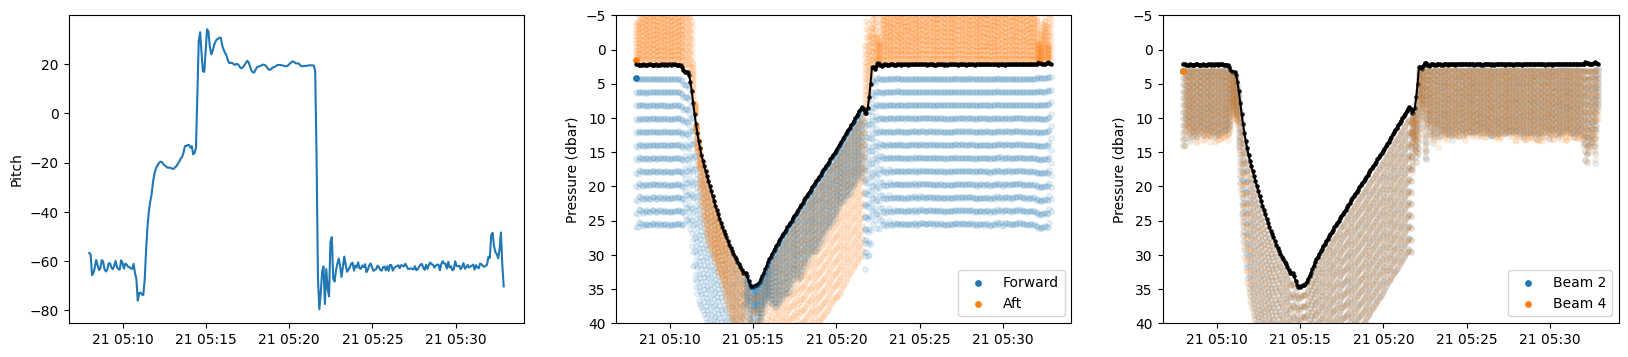

In [7]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

## 1.4 Correct ADCP Heading

The ADCP's compass is affected by both soft and hard iron magnetic contamination. Even the best ADCP compass calibration on land will be affected by power cycling the glider and charging rechargeable batteries. The ideal is to perform an *in situ* compass calibration. This is done in the same way as phone compasses are calibrated: we measure the magnetic field in all directions, providing magnetometer vectors in the x, y and z directions. Assuming an invarying magnetic field over the calibratin period, the norm of the x, y and z magnetometer vectors should remain constant, describing a perfect sphere around the compass.

We assume the magnetic field is invarying over the duration of the mission and translate the x, y, z vectors to centre around the compass (hard iron correction), then we transform the centrered ellipsoid to fit a sphere (soft iron correction). On all glider datasets that we have investigated, the hard iron error is by far larger than the soft iron correction, and is also the easiest to correct for.

Our compass correction scheme involves two steps which distinguish it from standard ellipsoid fits and increase robustness on gliders. 
1. Firstly, we look at accelerometer data on the ADCP and discard all data showing acceleration as this biases the data. Fits using steady ADCP data are significantly more robust. 
2. The second element is that gliders at sea, depending on latitude, rarely or never get magnetometer data with vectors extending towards the top of the glider (ie. equivalent to the glider being upside down). At low latitudes, in cases of steep pitch, the glider is able to collect data in both compass hemispheres. At high latitudes, we often lack data in one hemisphere. The hard iron calibration is easily performed on only one hemisphere (only non-aligned 3 data points are required technically), however the soft iron correction is more sensitive. We make the assumption that the spheroid is symmetrical and apply a symmetrical correction.

The figure below shows.....

TODO: Update with improved compass calibration script

TODO: Make soft iron correction optional


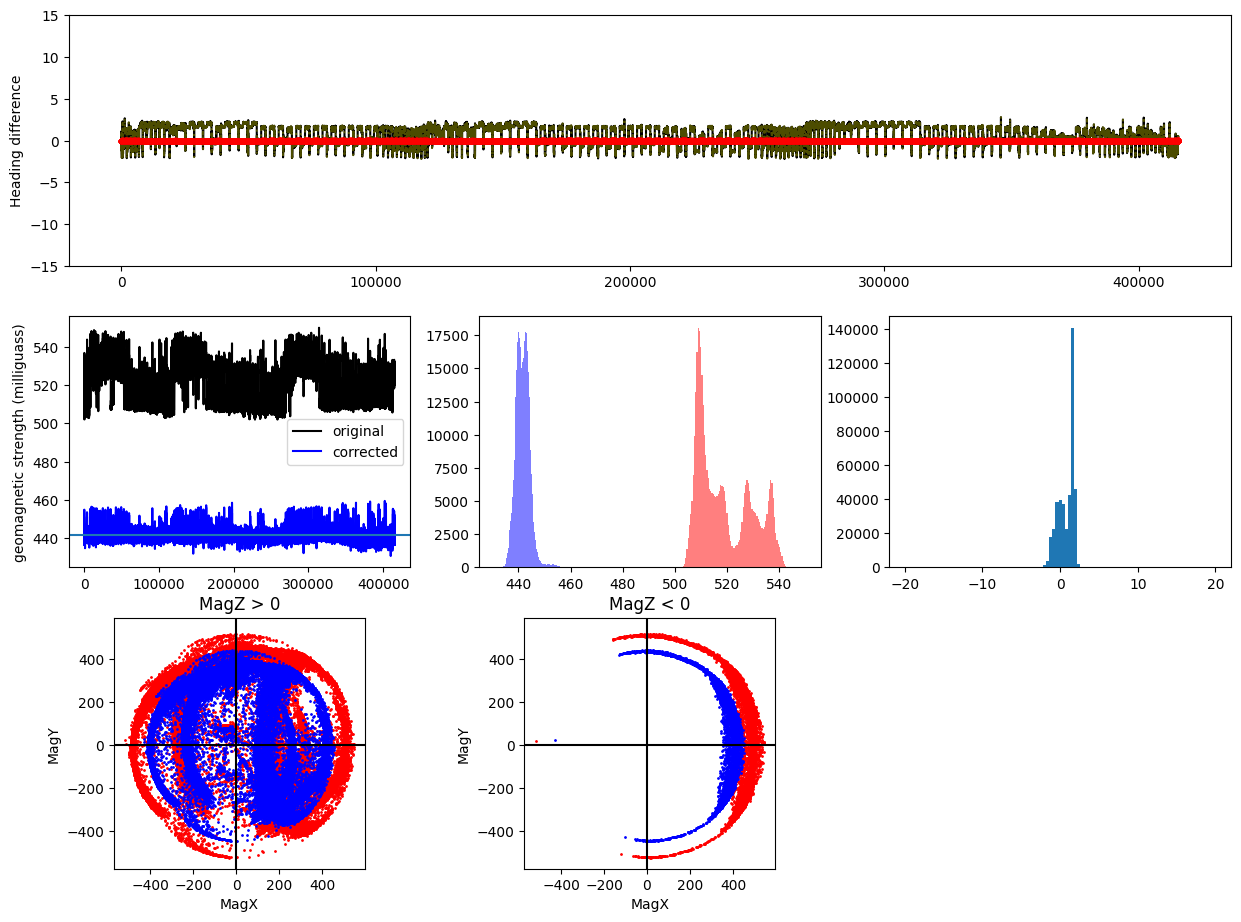

In [8]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## 1.5 Perform soundspeed correction

Perform the sound velocity correction using clean temperature and salinity data from the glider. The ADCP does not measure salininty and so estimates sound speed only based on its onboard temperature sensor.

The onboard sound speed is preserved in the Dataset as NoSal_Soundspeed. The velocities are corrected as :

$V_{corrected} = V_{measured} * \frac{SoundSpeed_{true},SoundSpeed_{NoSal}}$

In [9]:
ADCP = process_adcp.soundspeed_correction(ADCP)

## 1.6 Outlier and poor correlation removal

Here we get our first look at the data.

Each figure is provided twice, once before QC, and once after QC.

TODO : Compare U/D profiles for time averaged figures
TODO : Keep only steady mid water sections




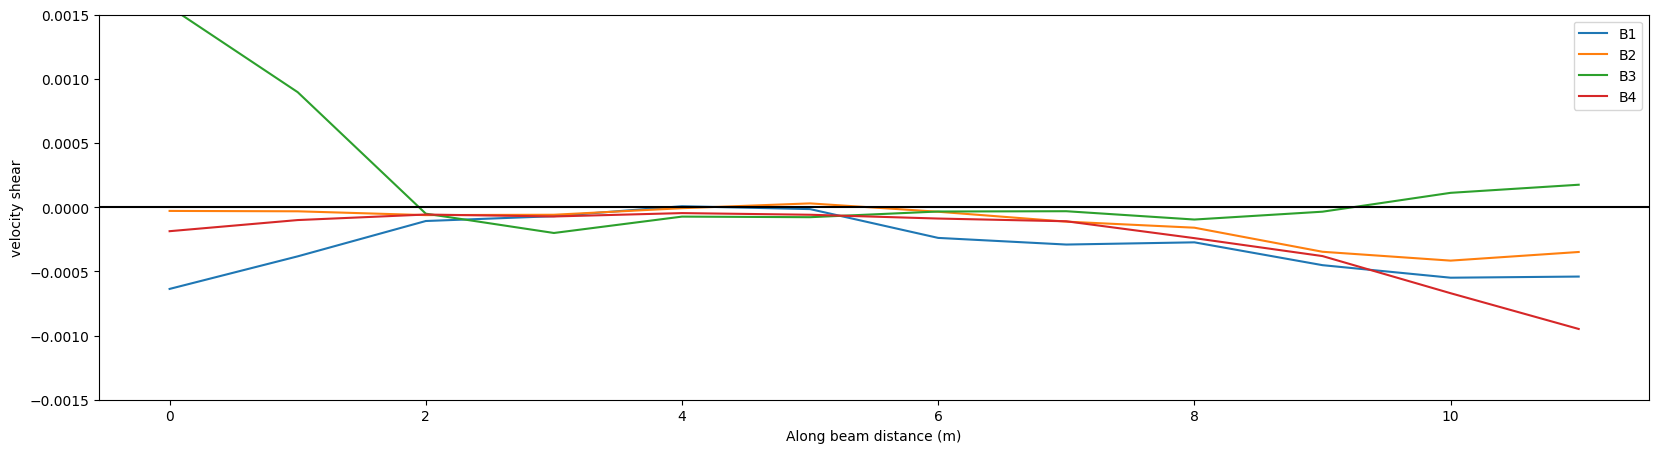

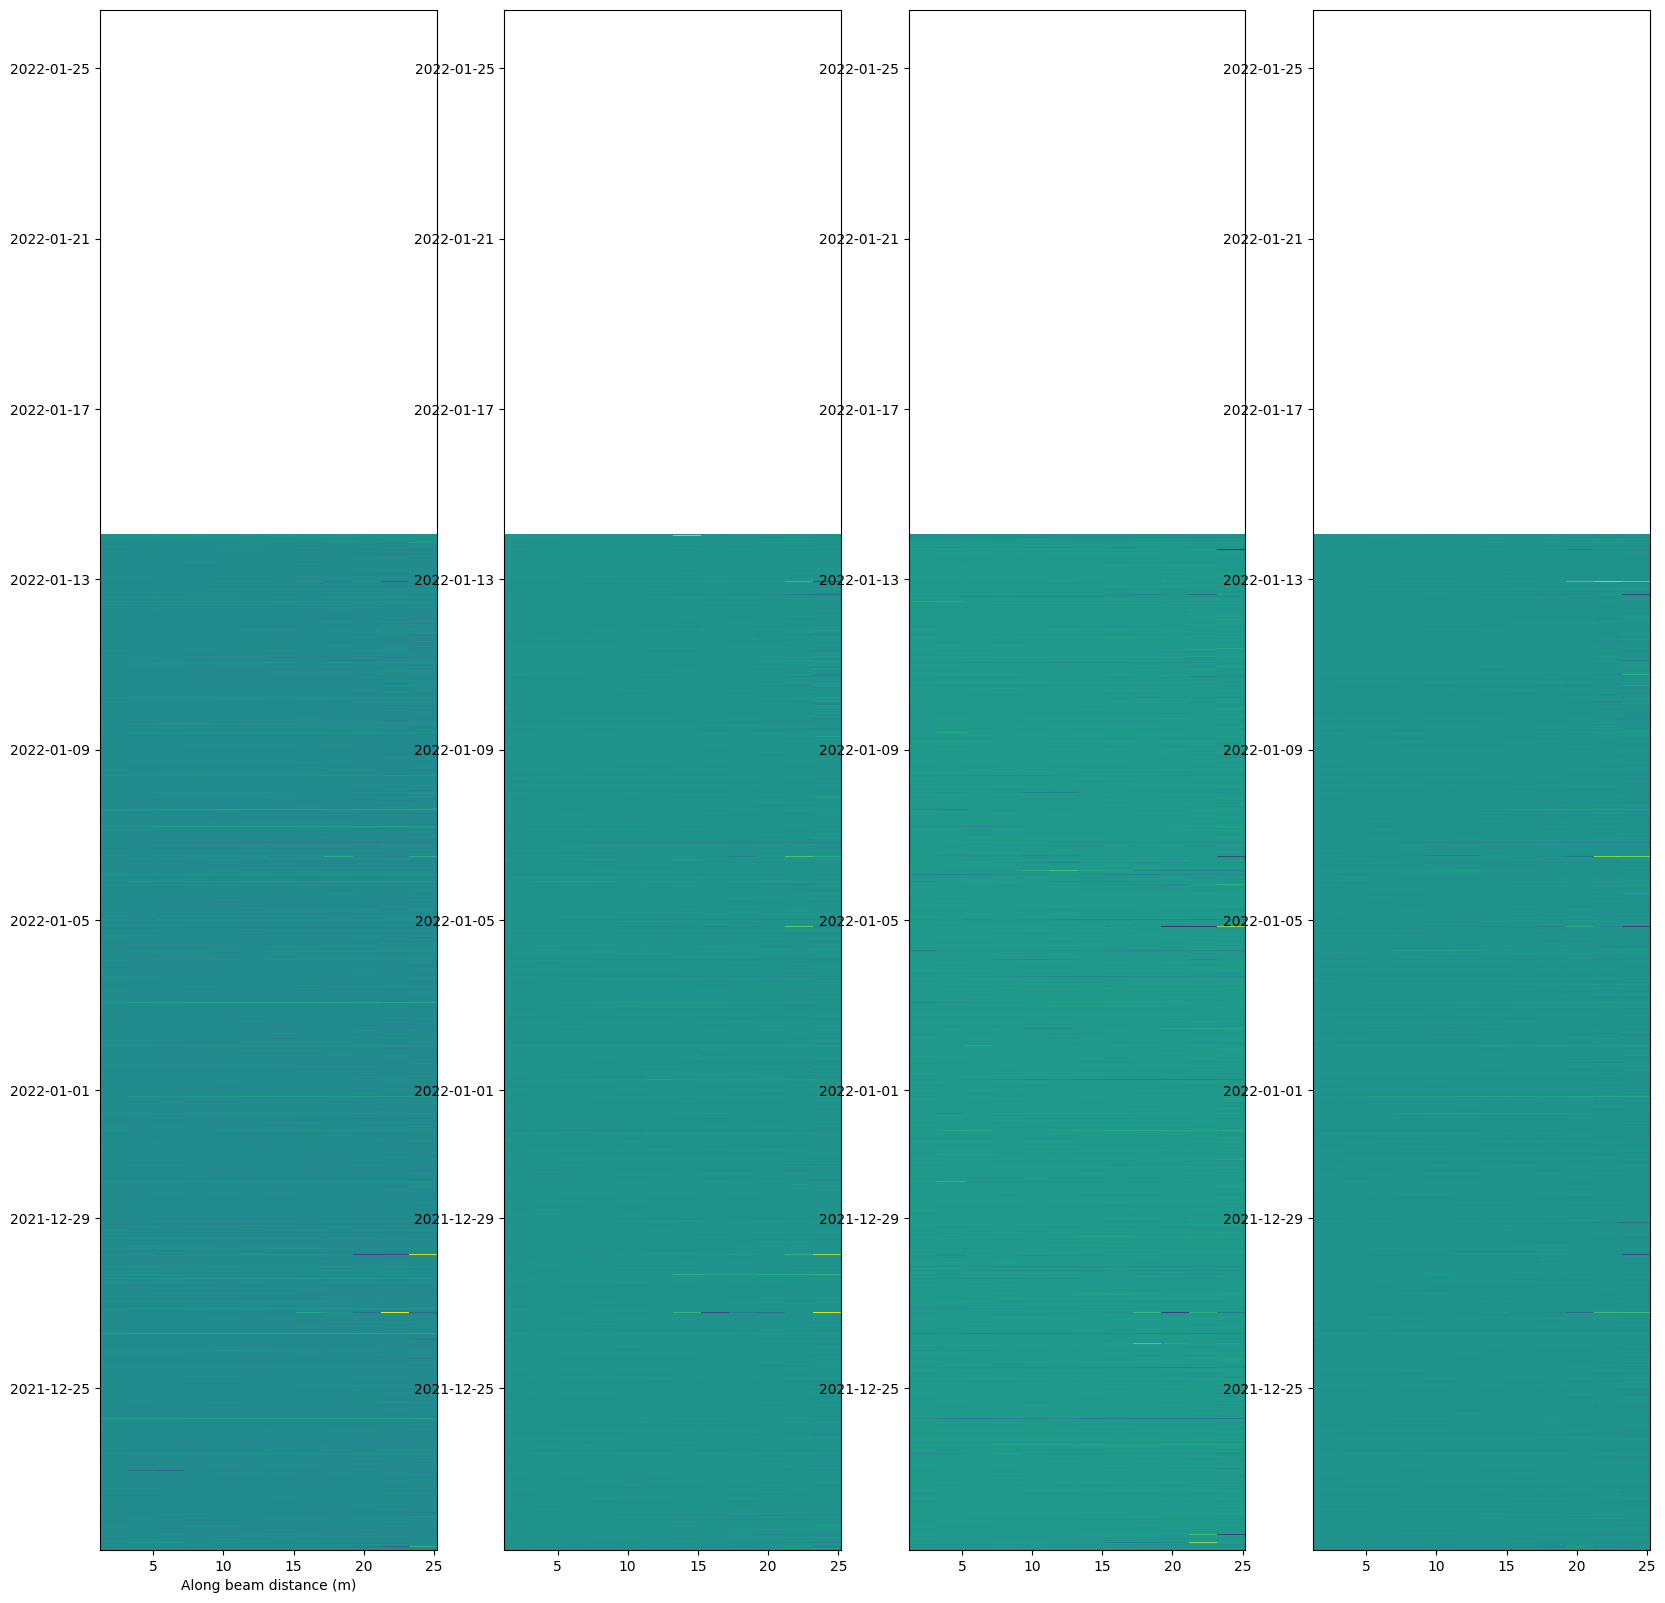

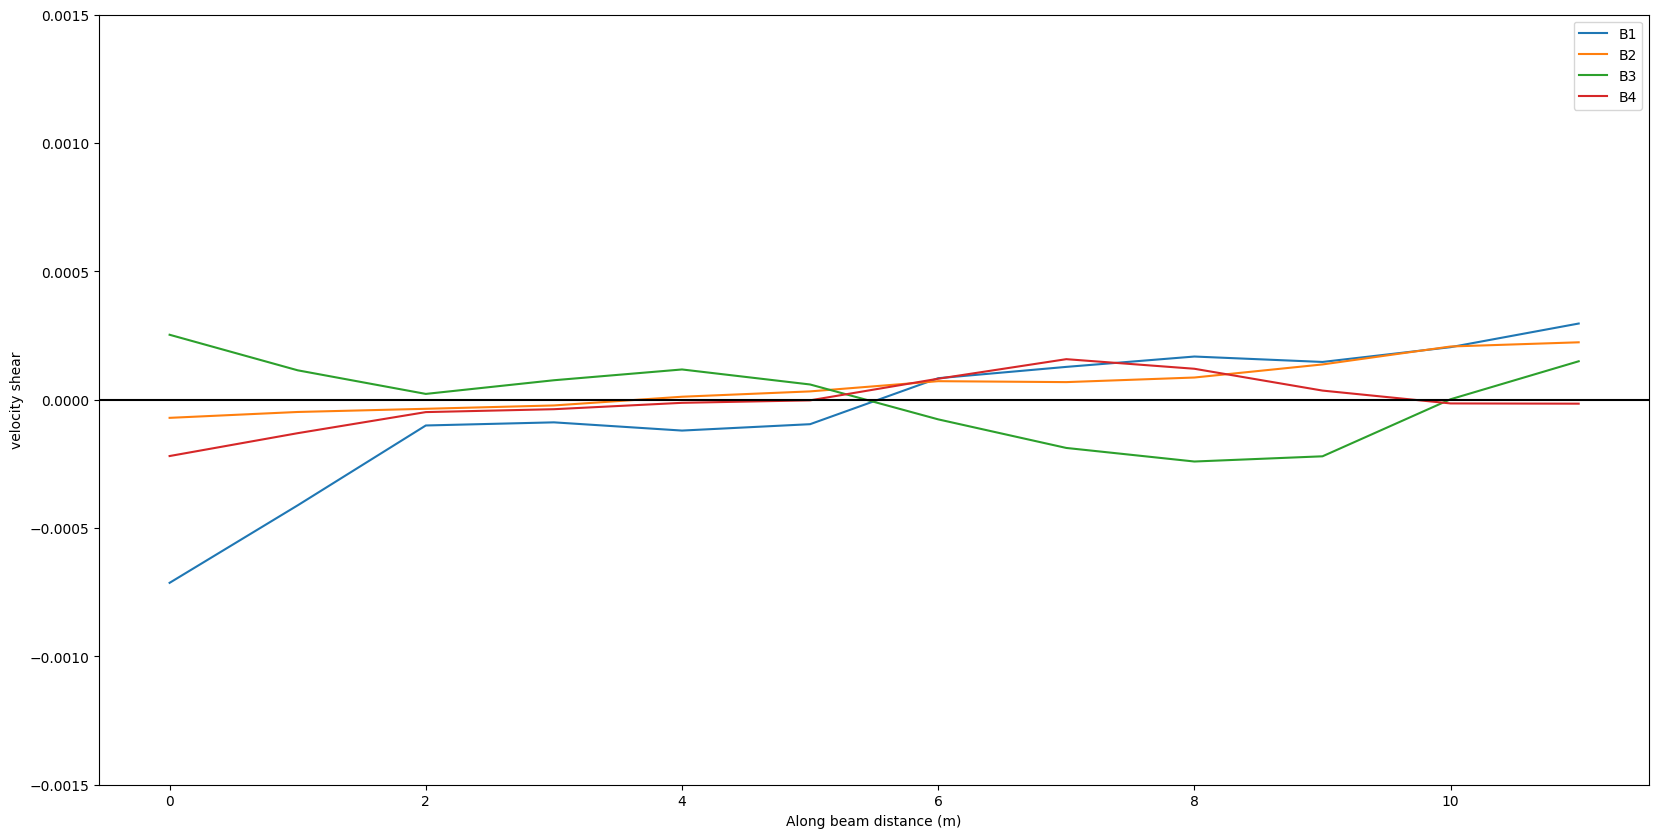

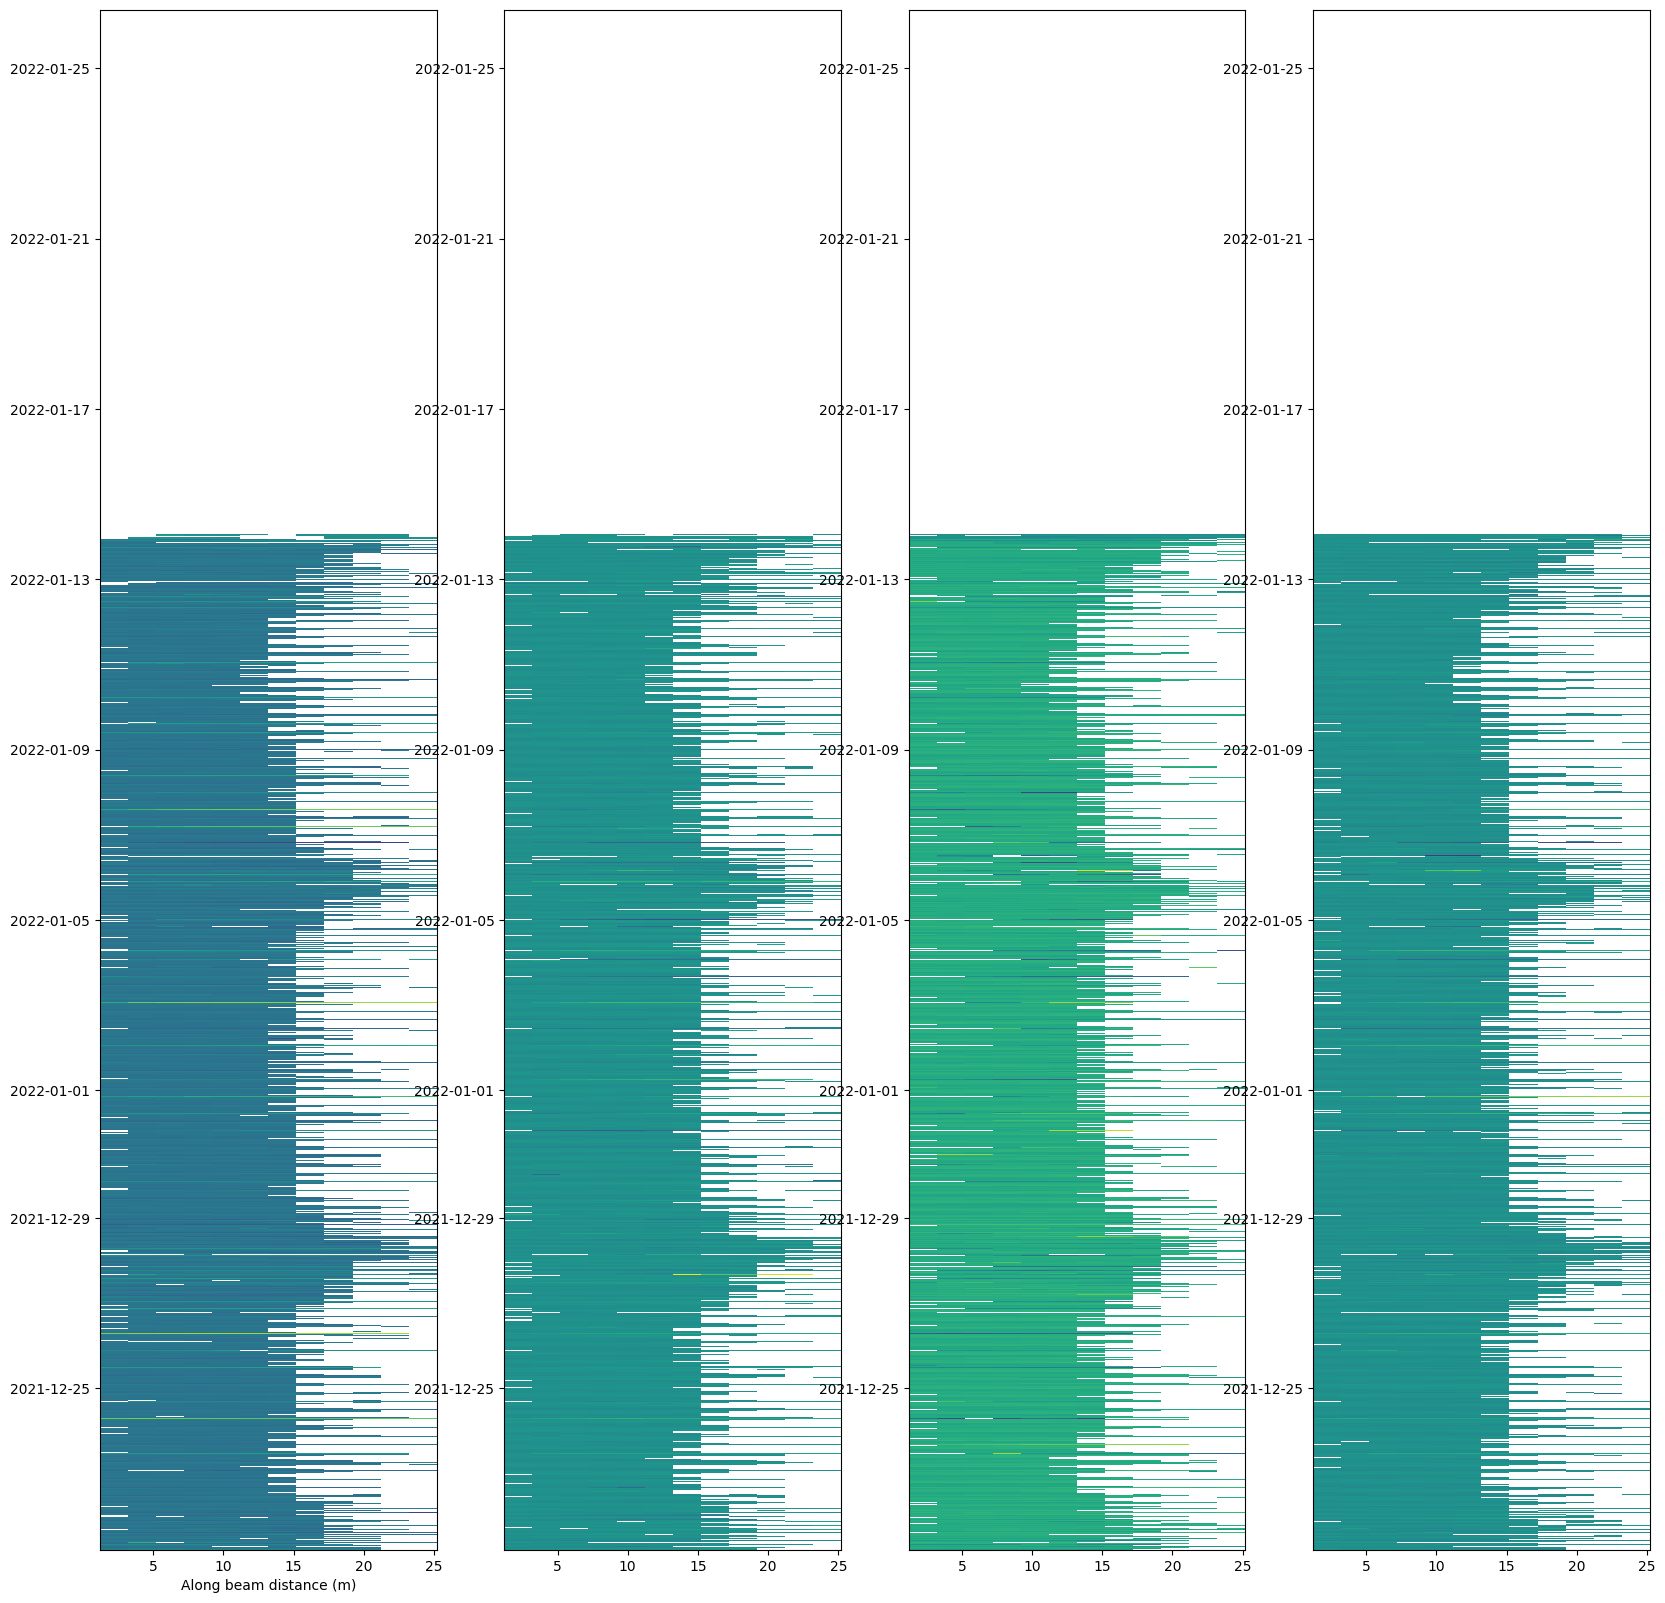

In [10]:
ADCP = process_adcp.remove_outliers(ADCP, options)

## 1.7 How many good data per bin?

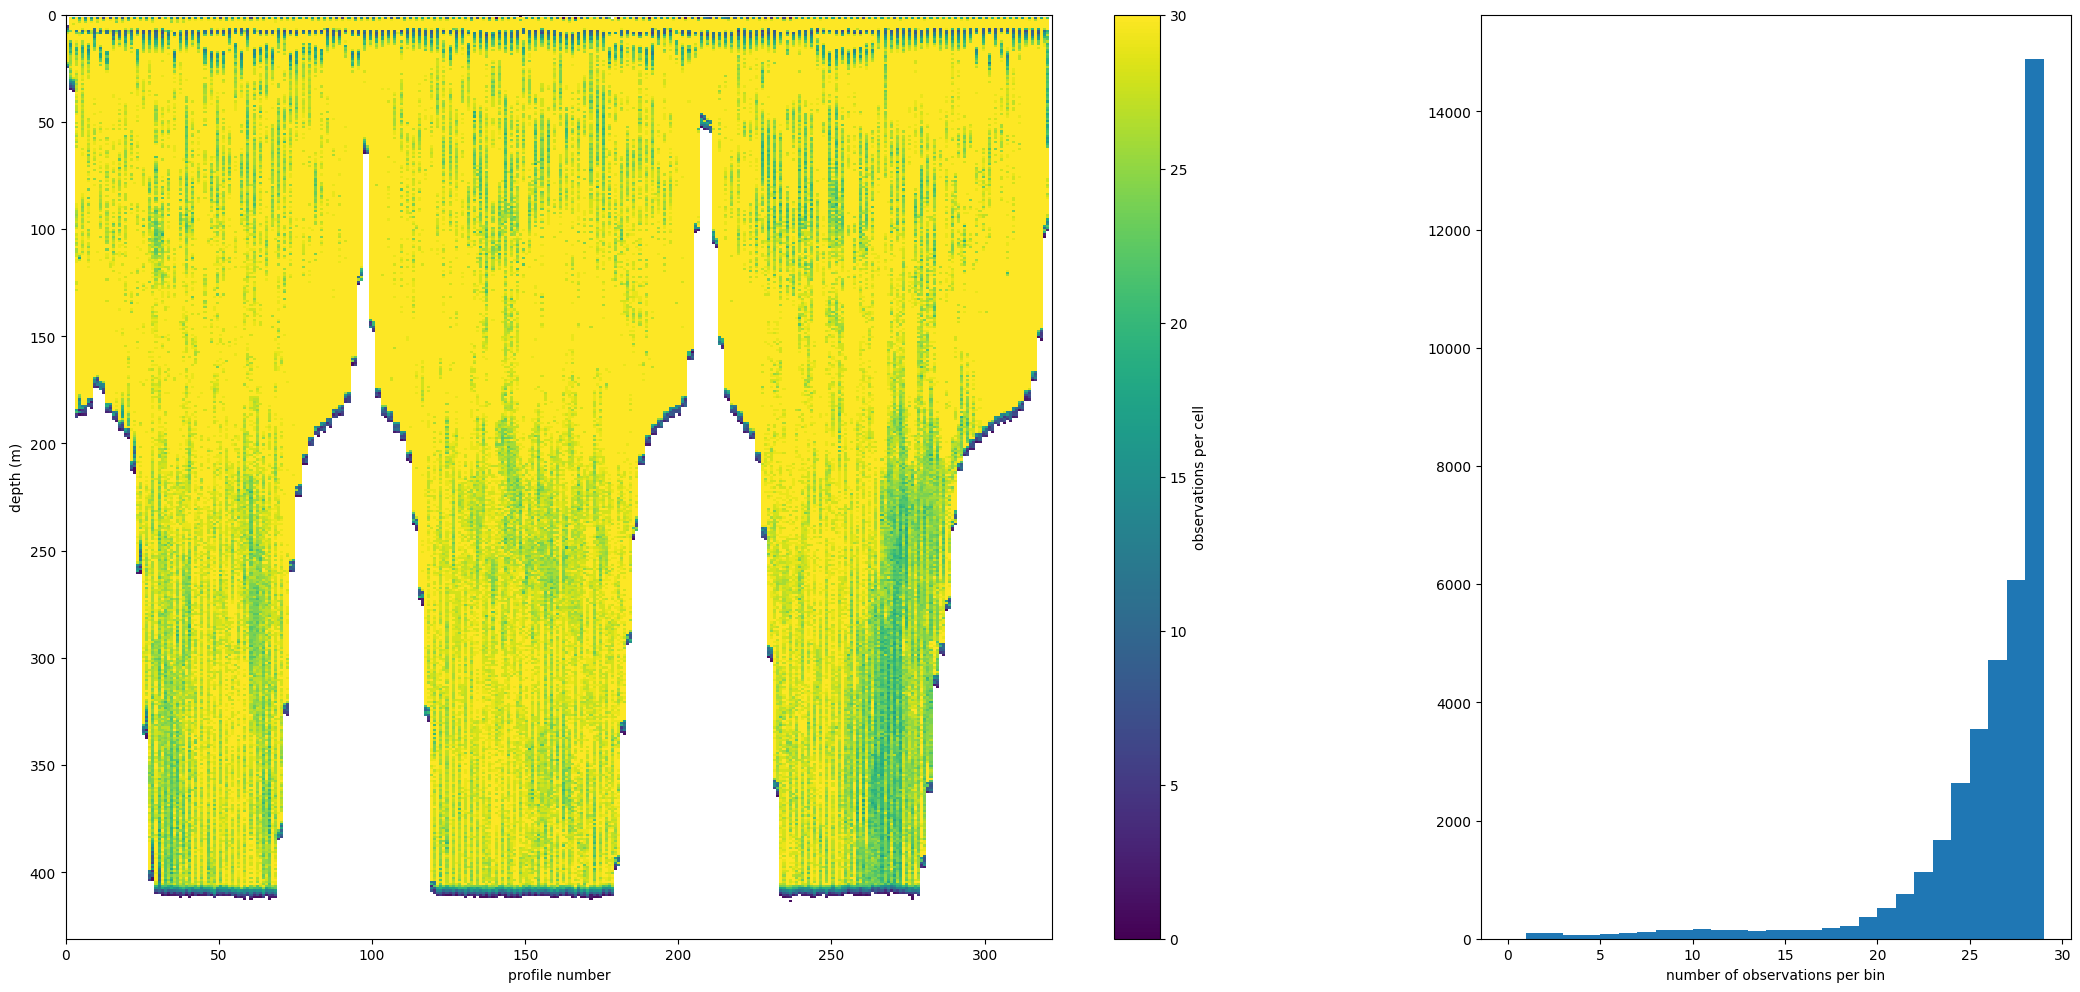

In [11]:
process_adcp.plot_data_density(ADCP, options)

### 1.8 Correct shear bias

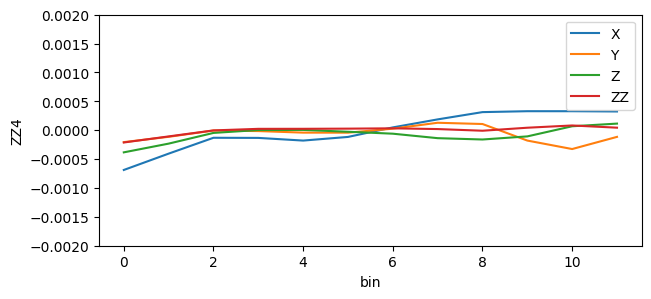

In [12]:
ADCP = process_adcp.correct_shear(ADCP, options)

## 1.9 Remap 3-beam configuration onto isobars

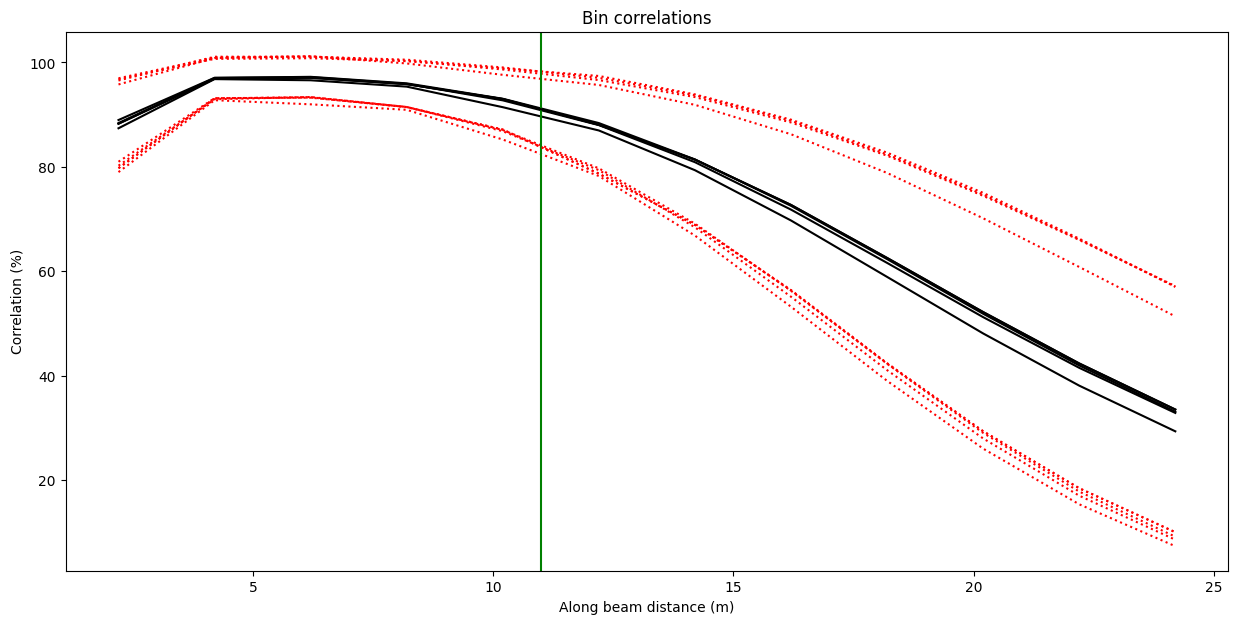

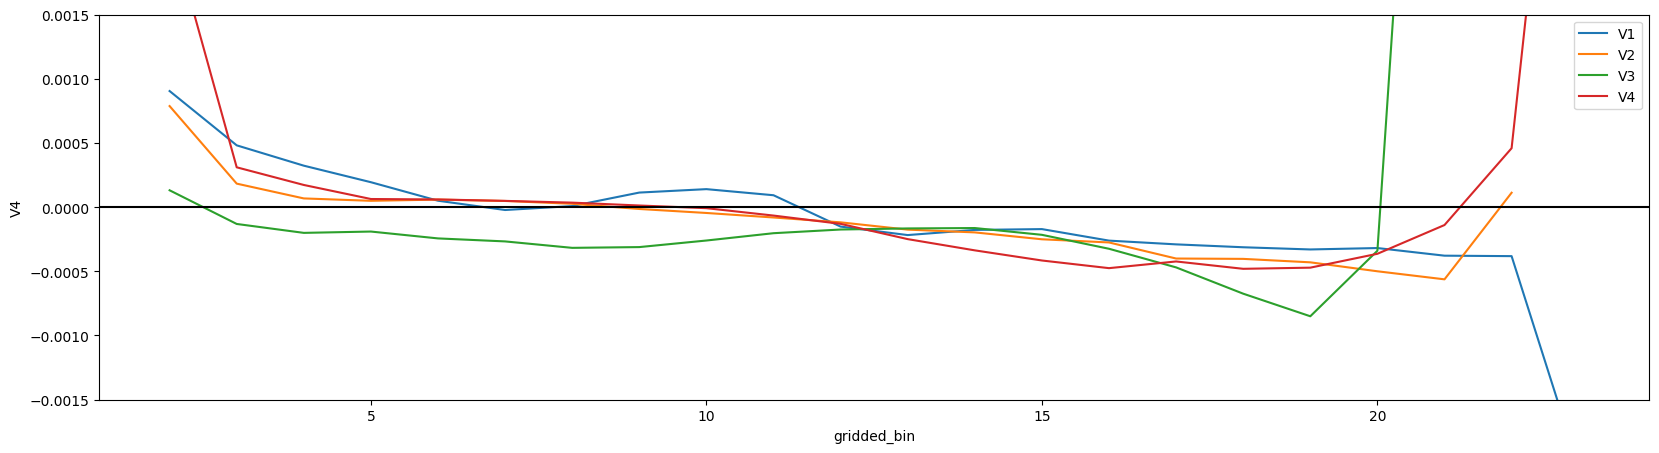

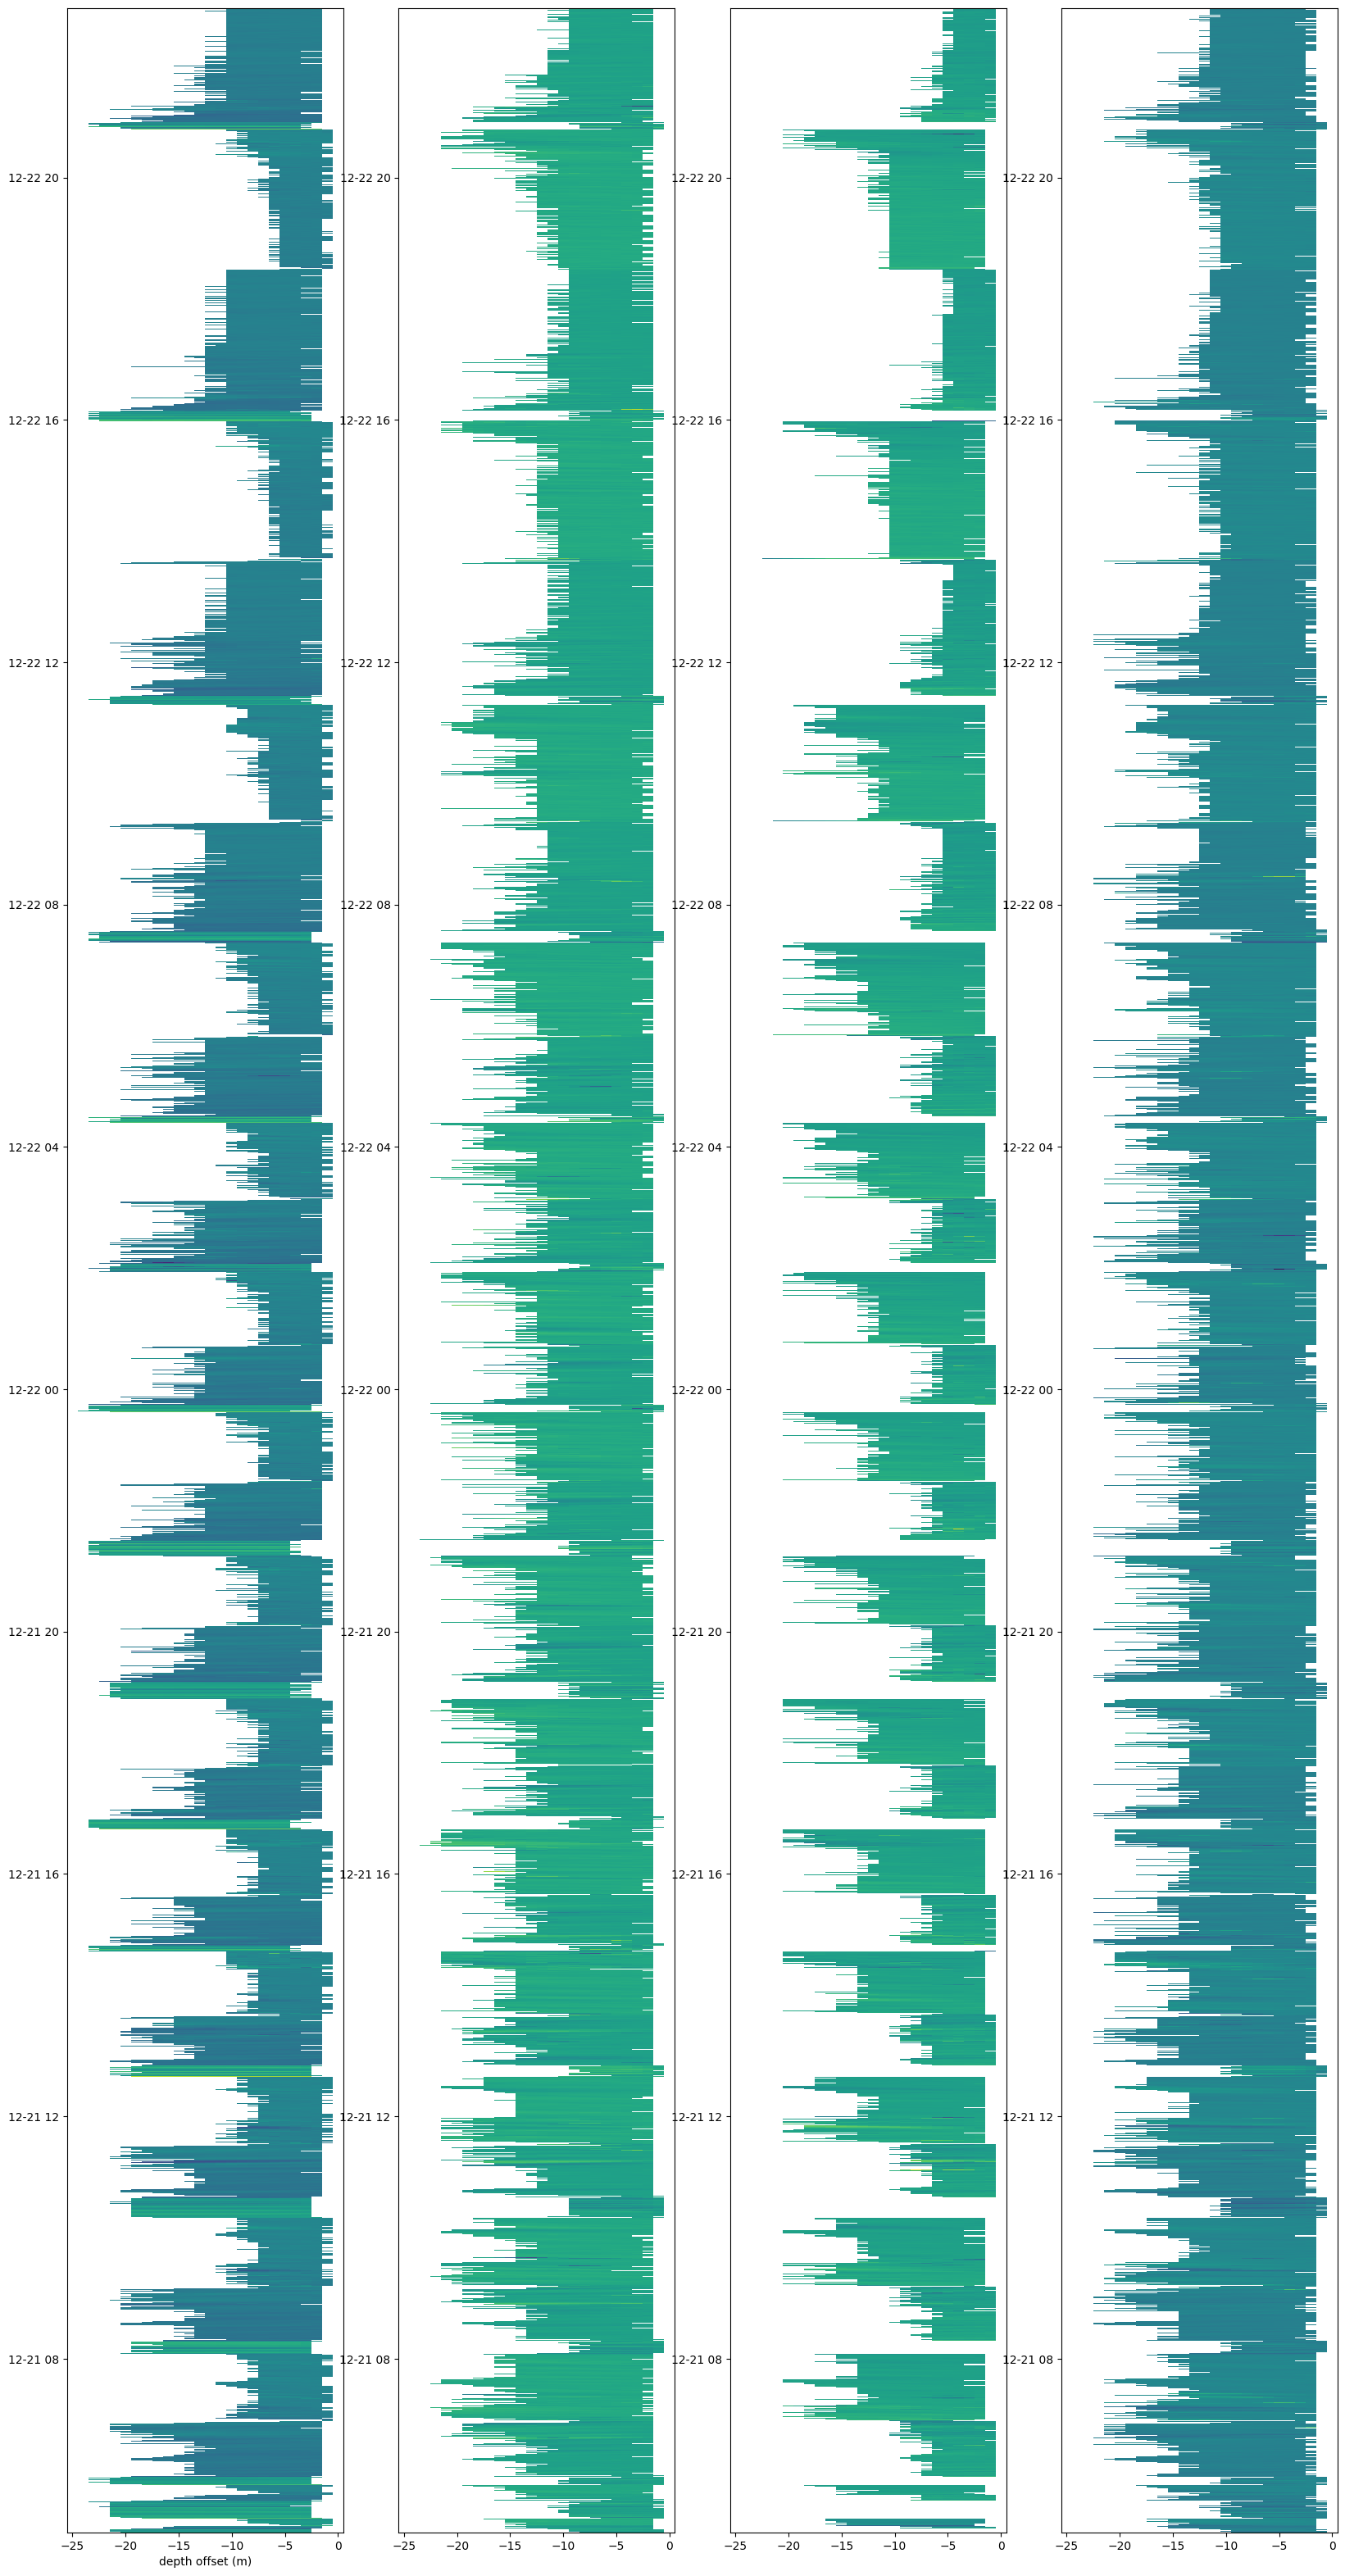

In [13]:
ADCP = process_adcp.regridADCPdata(ADCP, options)

## 1.10 Transform beams to XYZ and ENU velocities

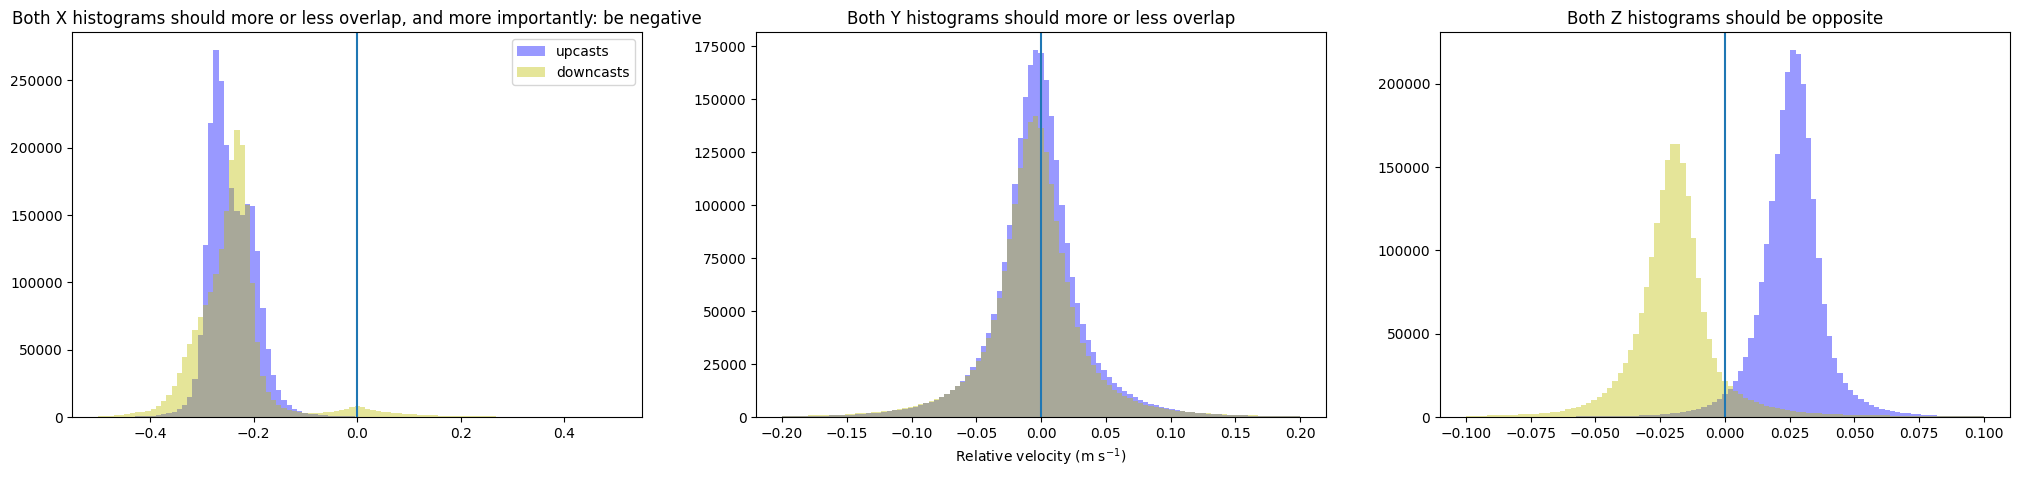

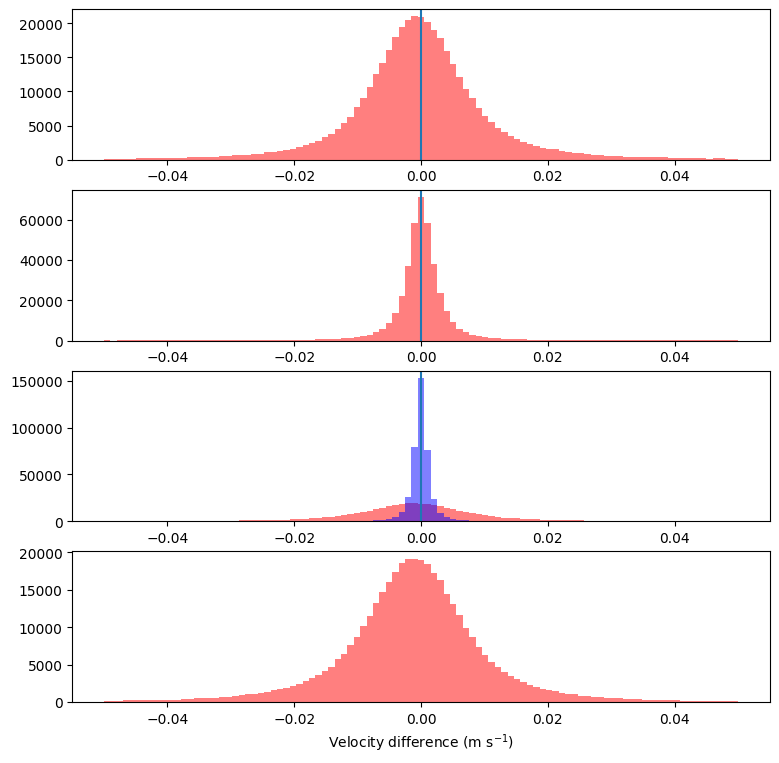

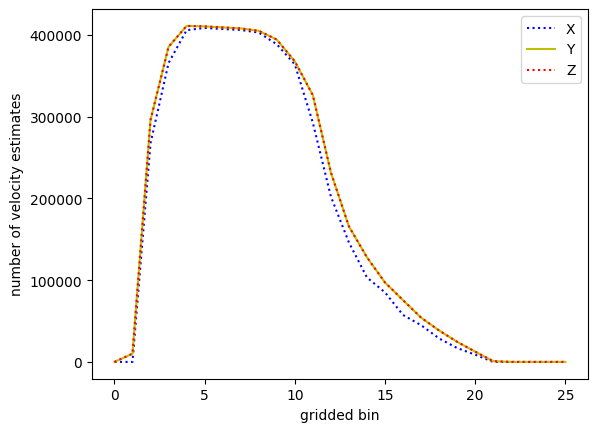

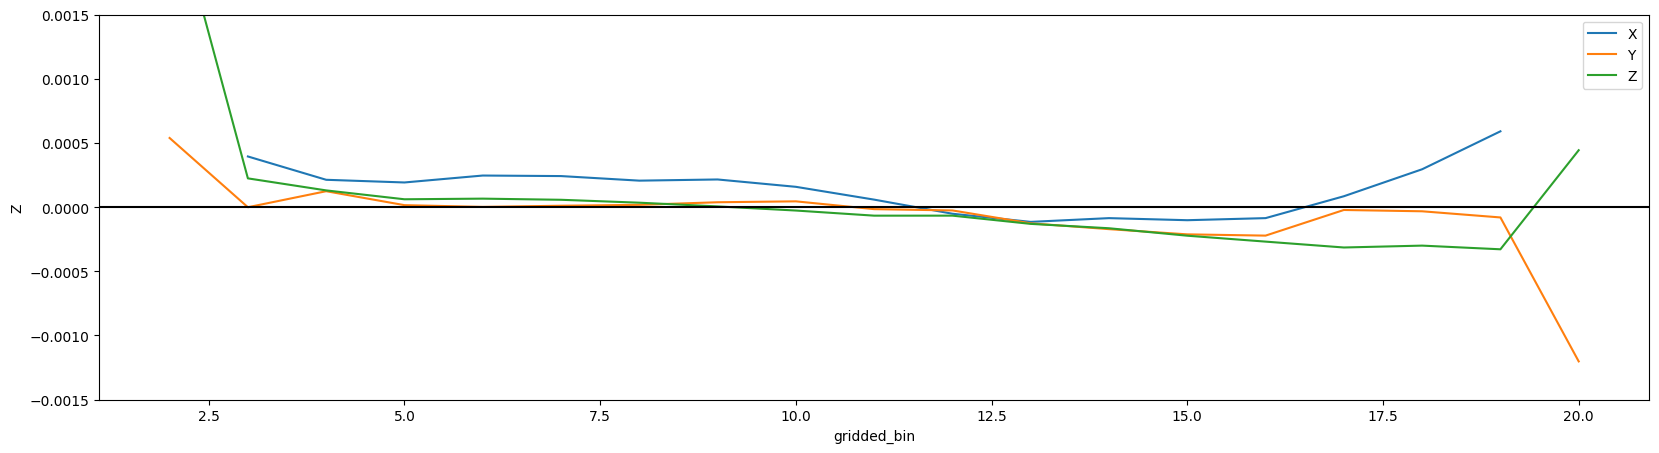

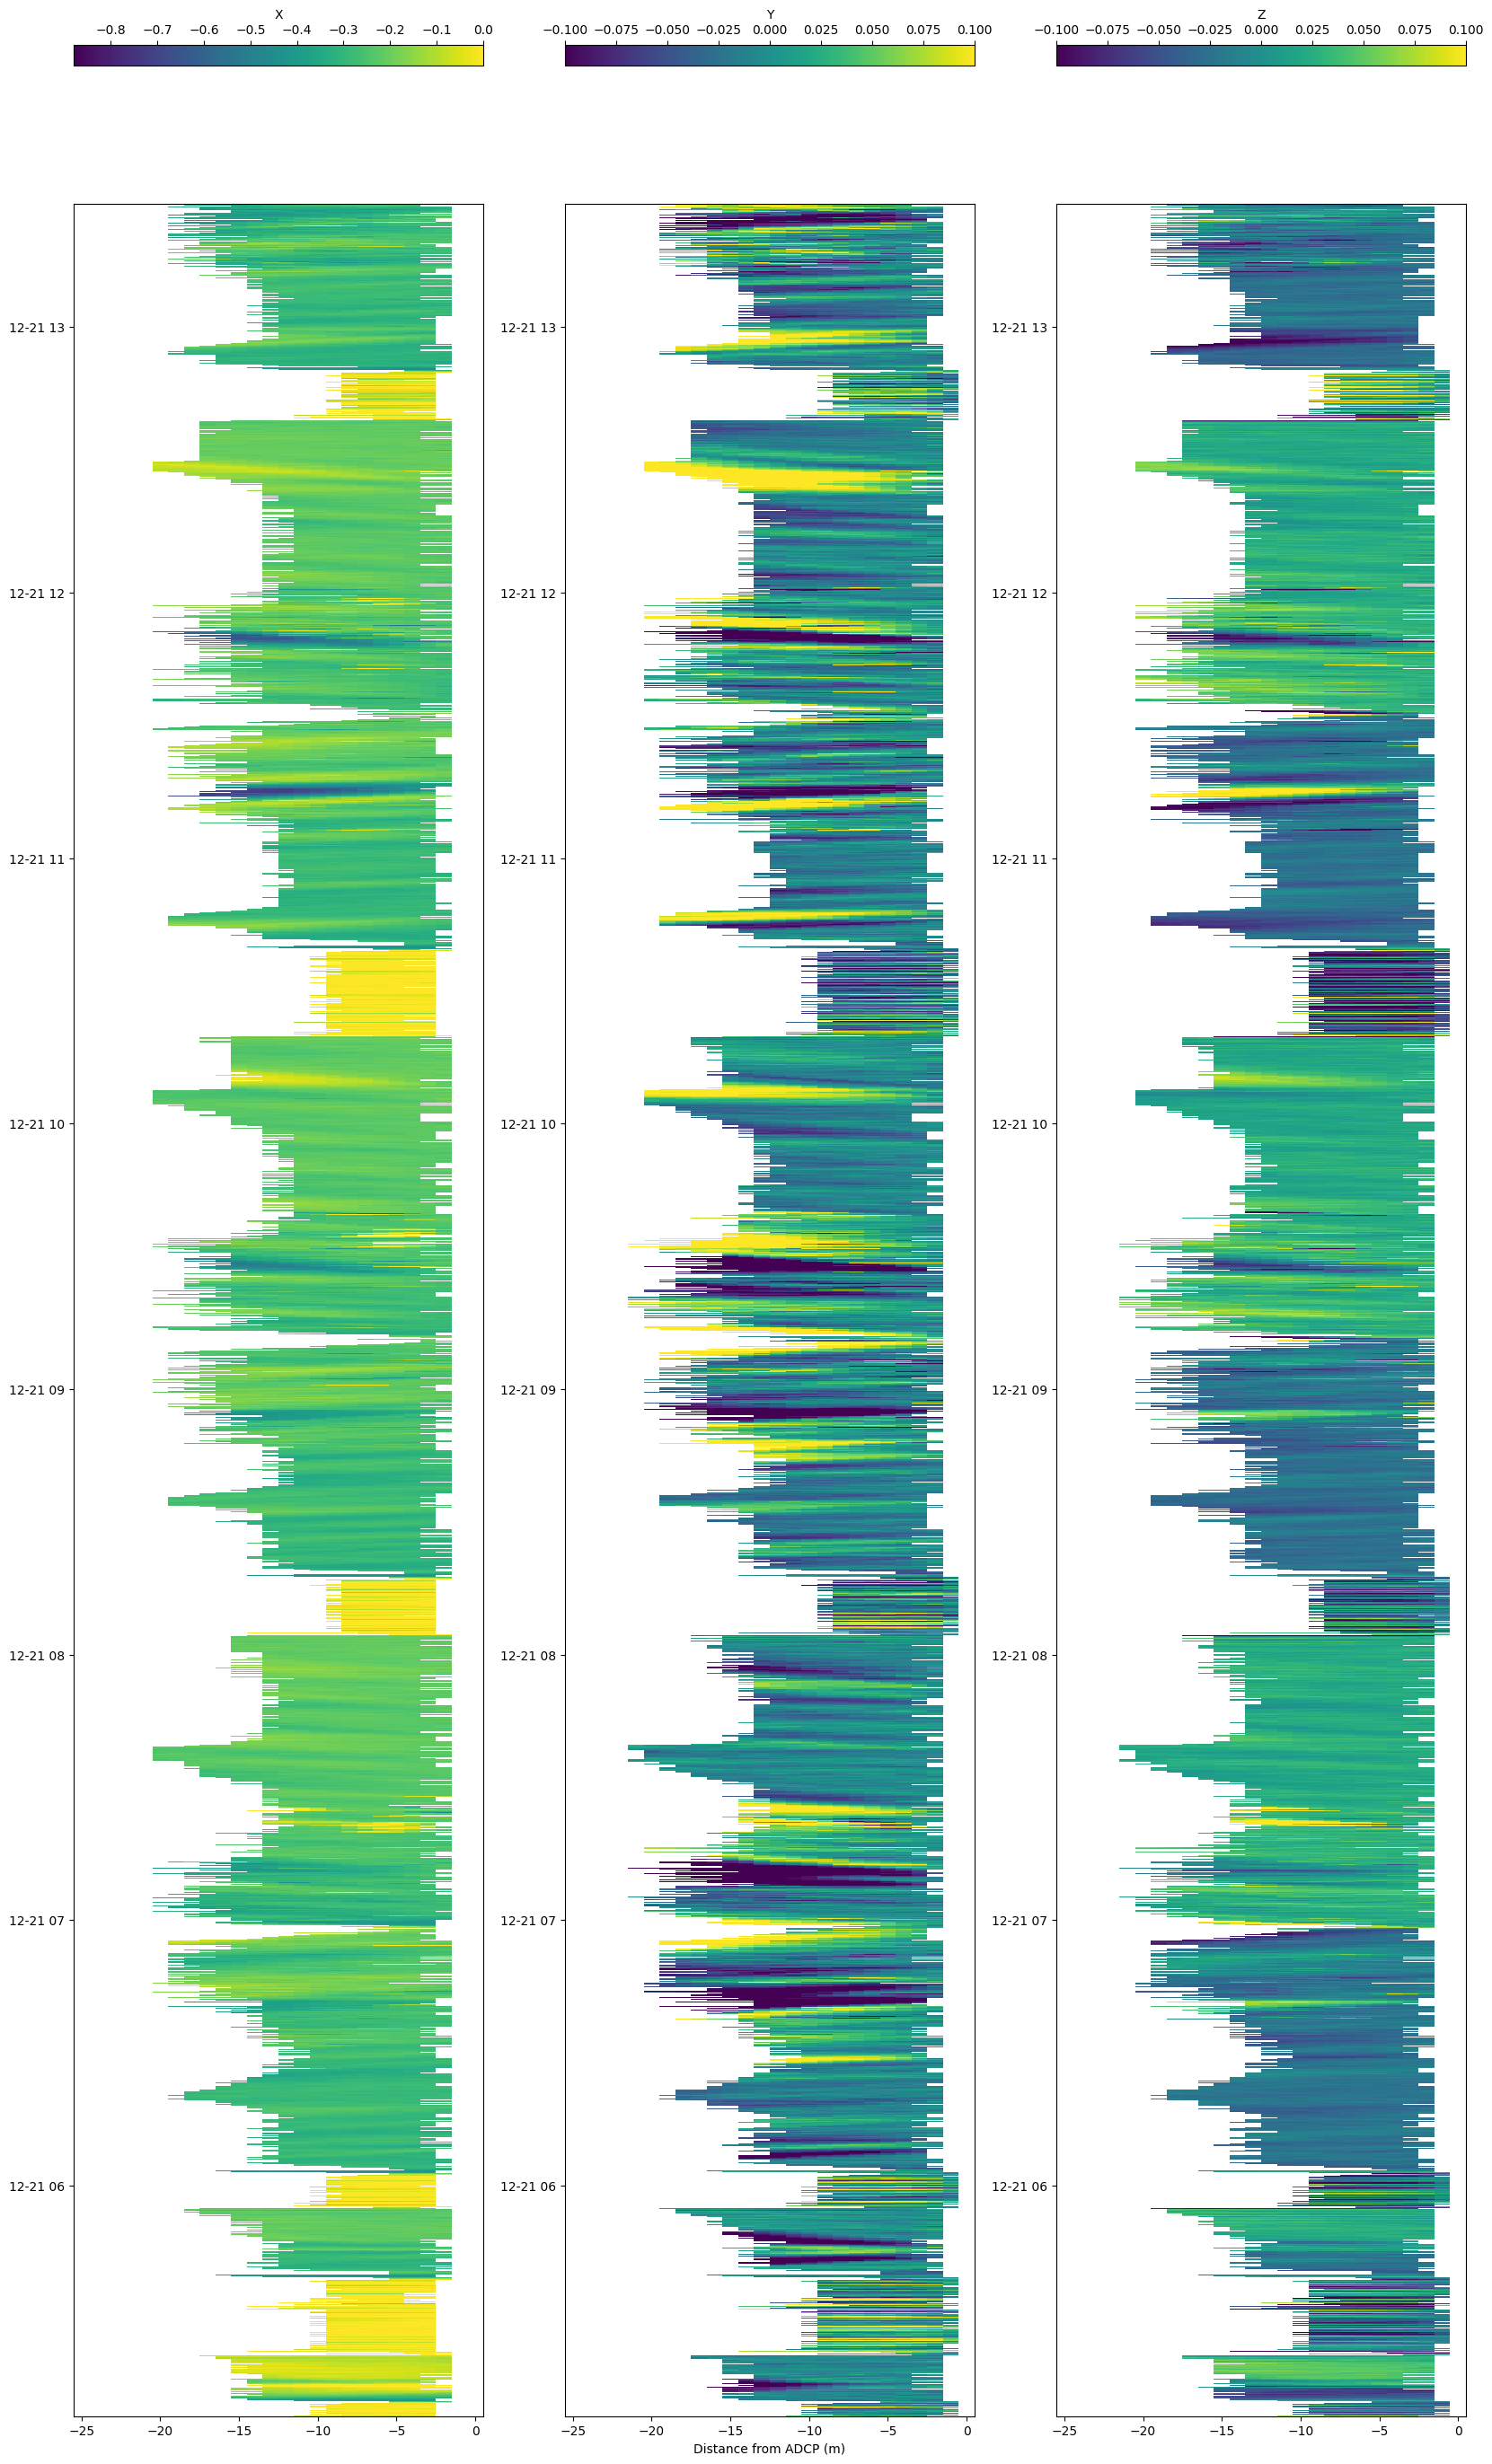

In [14]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

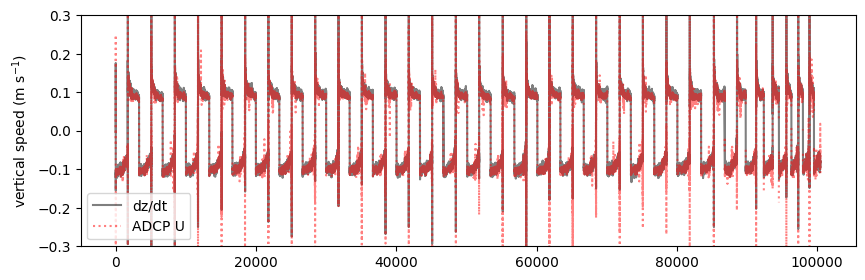

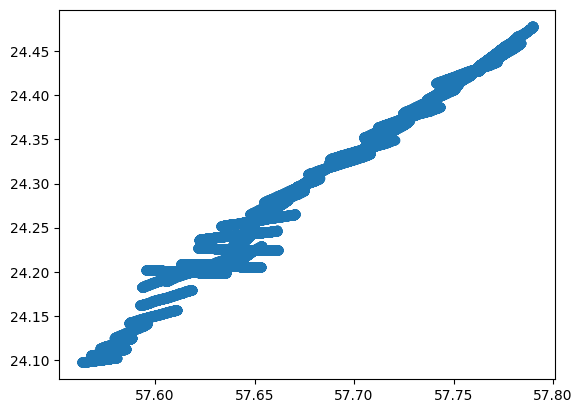

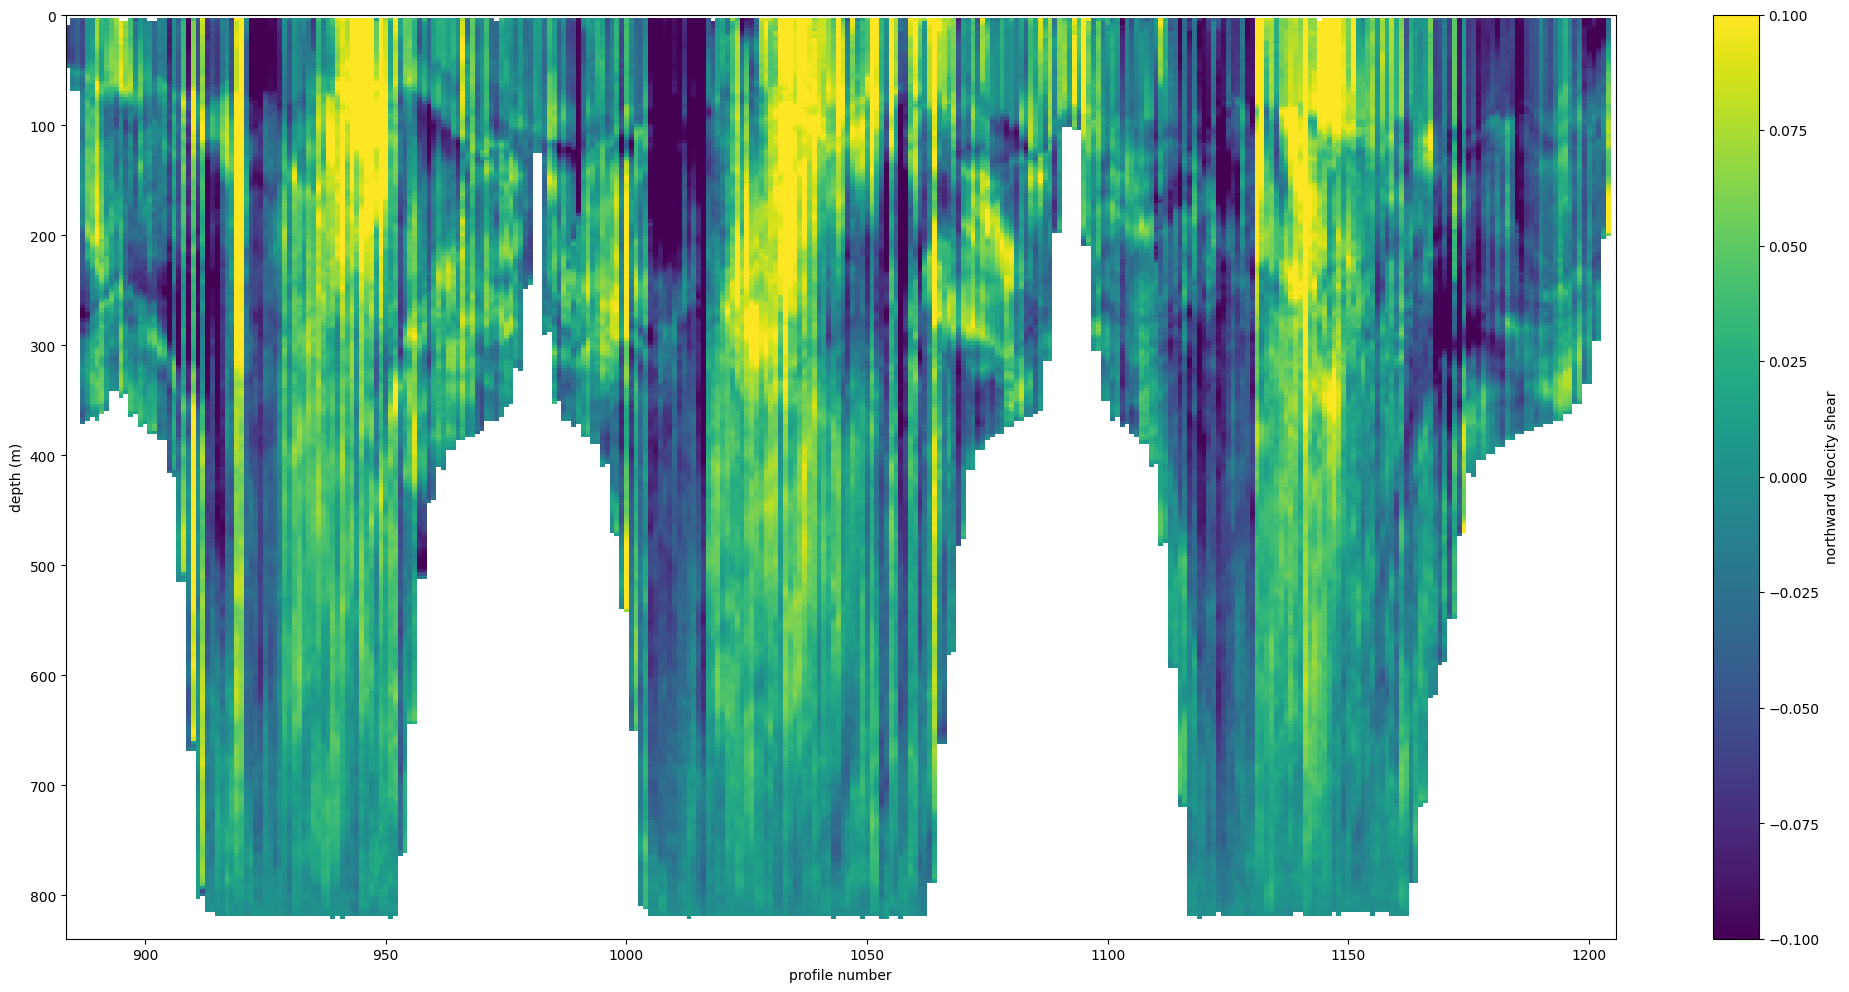

In [15]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

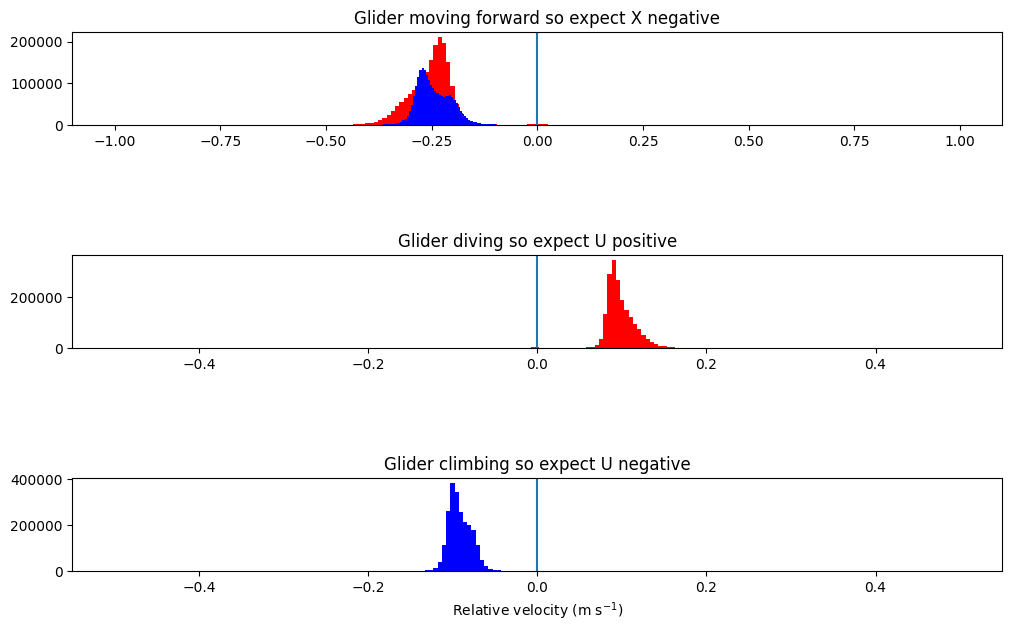

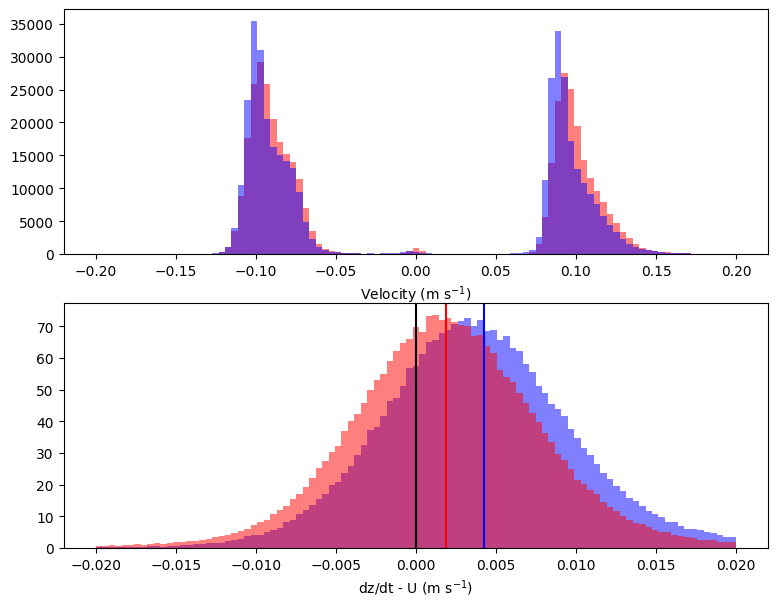

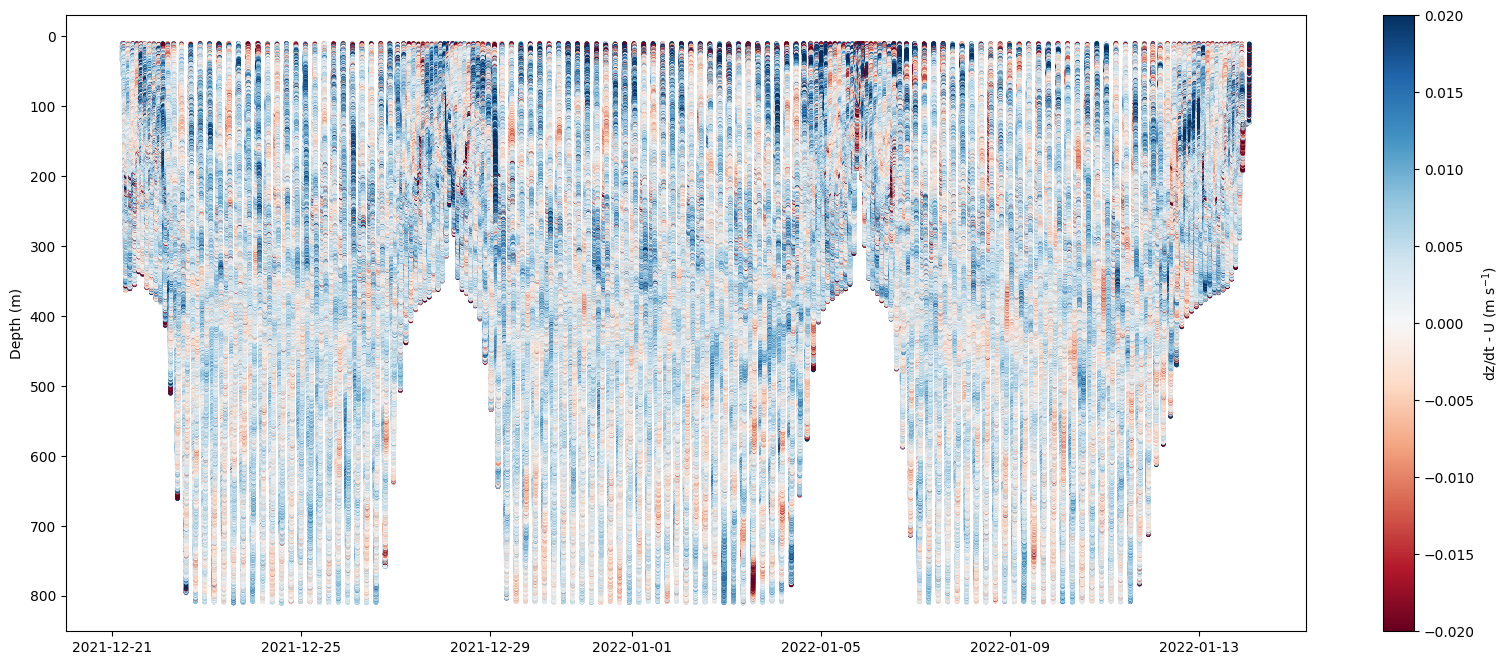

In [16]:
process_adcp.verify_calcENUfromXYZ(ADCP, options)

## 1.11 Grid shear

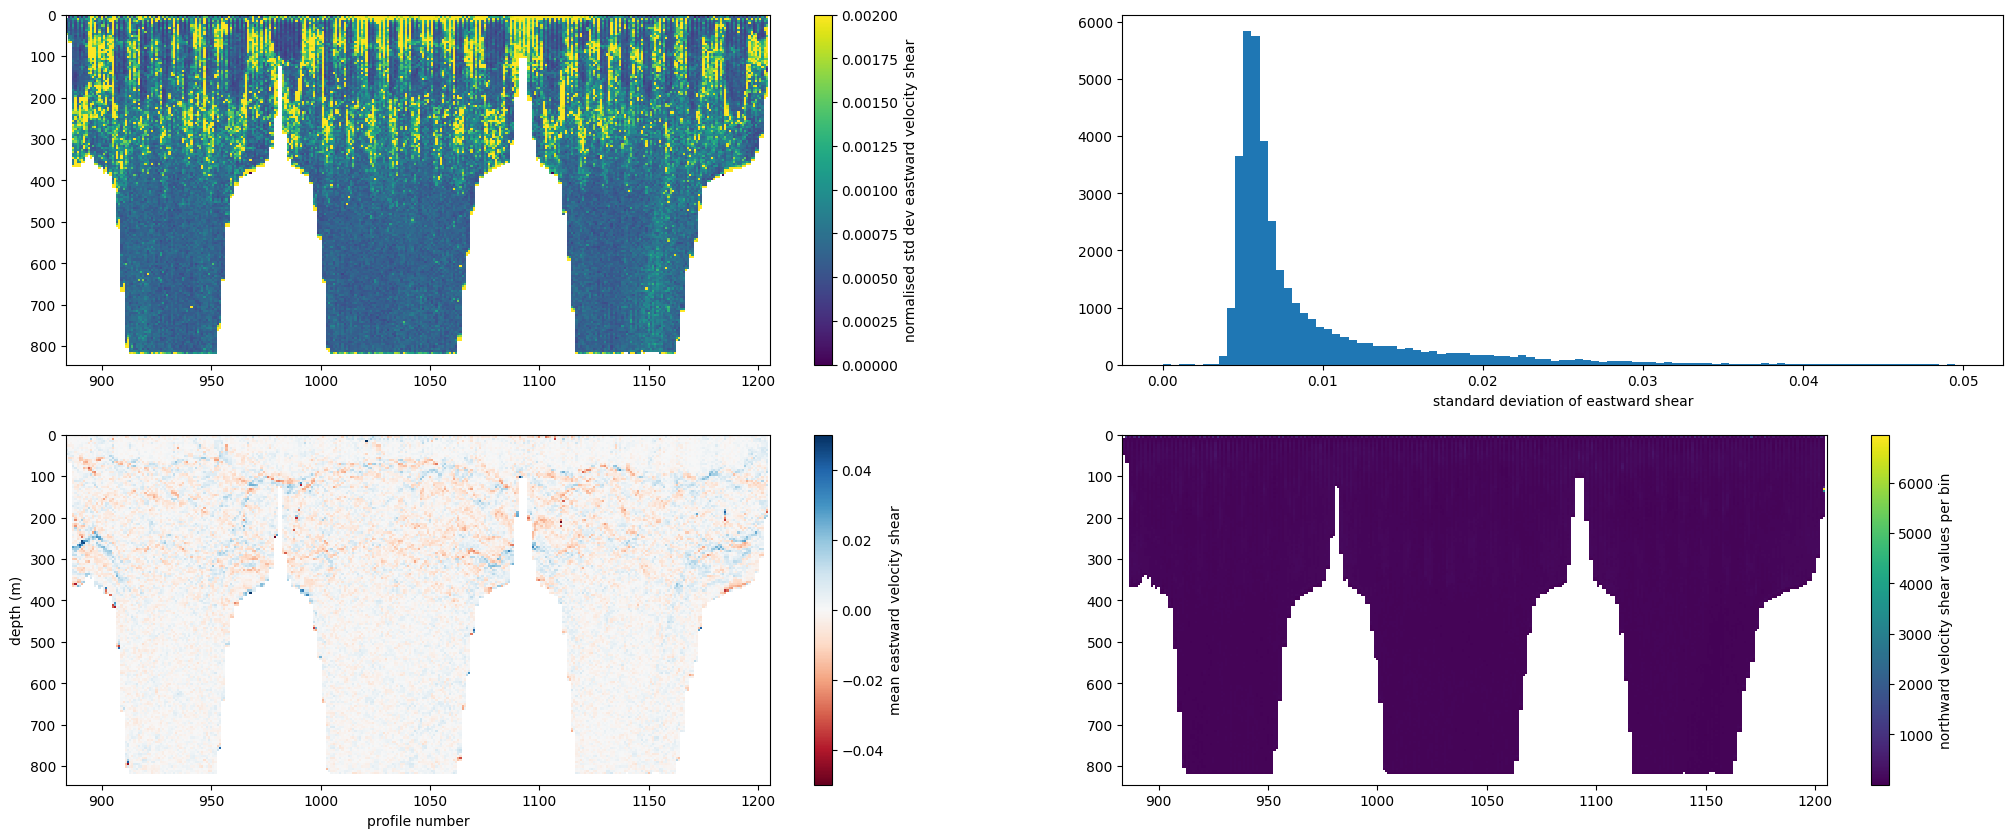

In [17]:
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)
out = process_adcp.grid_data(ADCP, data, {}, xaxis, yaxis)
ds = process_adcp.make_dataset(out)

# 1.12 Write out data

**ds** is an xarray dataset of data gridded by depth bin and profile number, ready for processing

In [18]:
ds.to_netcdf("gridded_shear.nc")

# Part 2: shear to velocity

After calculating velocity shear, there are several options for integrating and referencing this shear to obtain velocity profiles. This section demonstrates some of these options

# 2.1 Add extra variables for integrating shear

To calculate dive average current we require more variables, including estimates of the glider's movement through the water.

In [19]:
import pandas as pd

extra_data = pd.read_parquet(glider_pqt_path)
extra_data.index = data.index
data["speed_vert"] = extra_data["speed_vert"]
data["speed_horz"] = extra_data["speed_horz"]
data["dead_reckoning"] = extra_data["dead_reckoning"]
data["nav_resource"] = extra_data["nav_state"]
data["dive_number"] = extra_data["dive_number"]

## 2.2. Calculate dive-averaged current

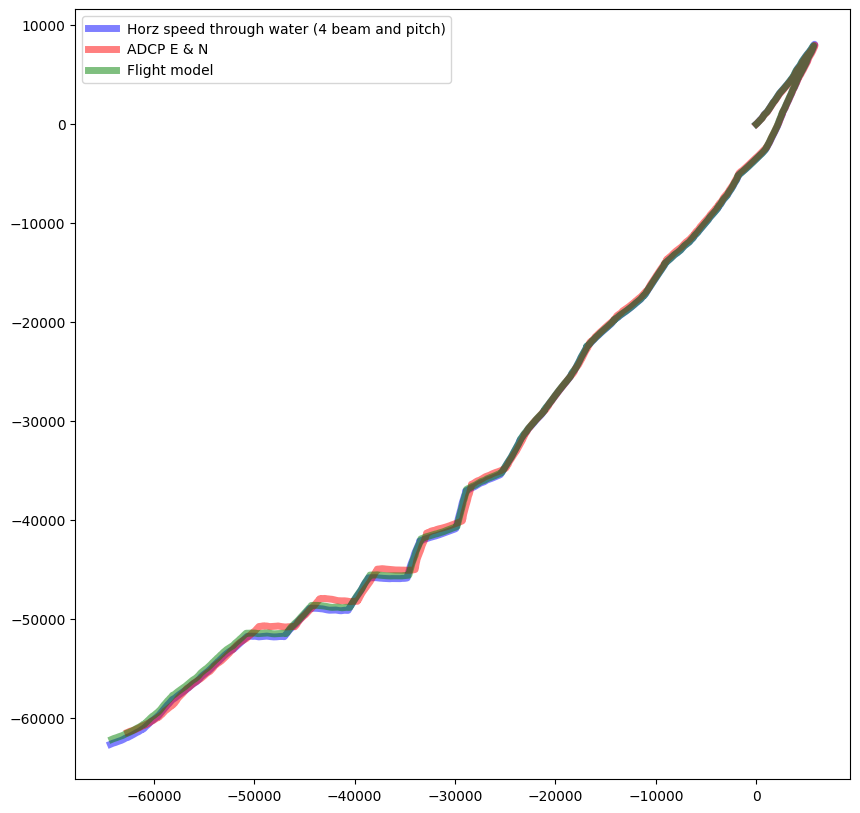

In [20]:
process_adcp.plot_subsurface_movement(ADCP, data, options)

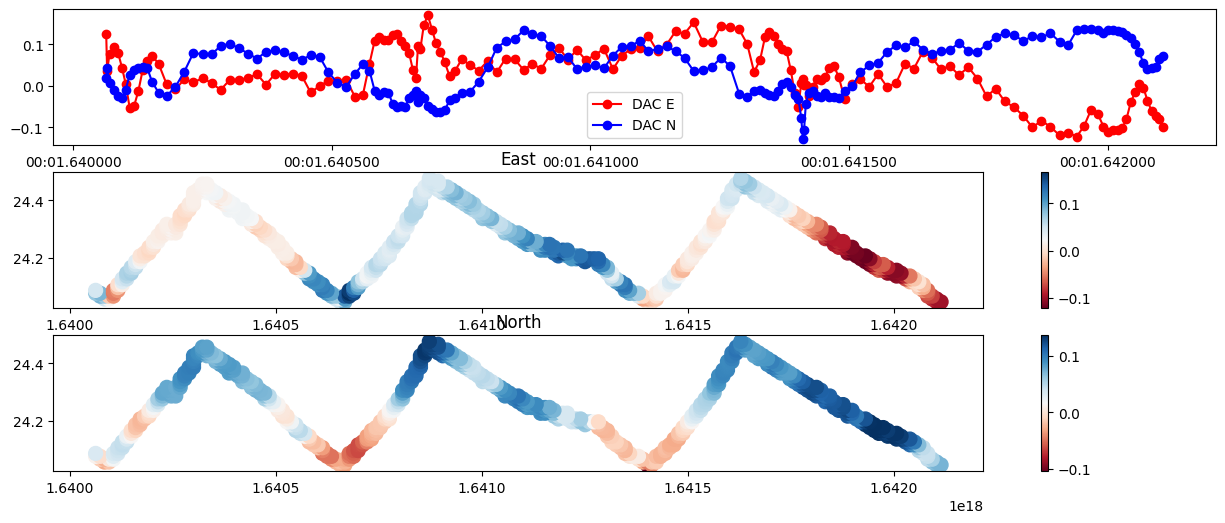

In [21]:
data = process_adcp.get_DAC(ADCP, data, options)

## 2.3. Get surface drift

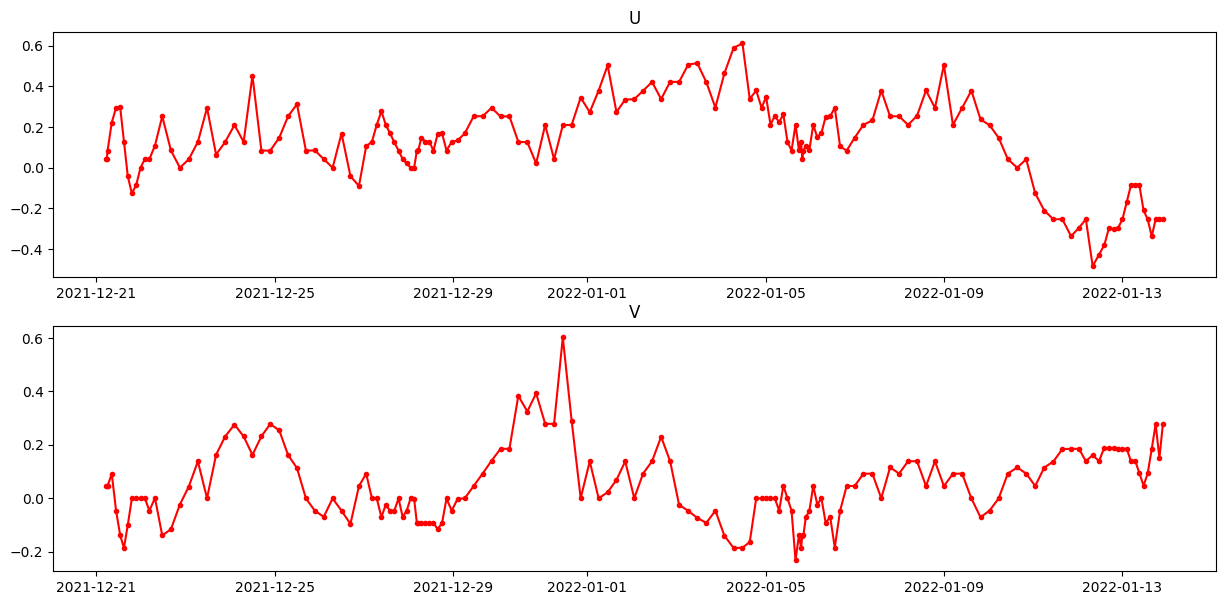

In [22]:
dE,dN,dT = process_adcp.getSurfaceDrift(data, options)

## 2.4. Get bottom track data 
Bottom track data only calculated if the ADCP is bottom mounted

In [23]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

## 2.5. Reference ADCP data

Here we reference data to dive average current (DAC).

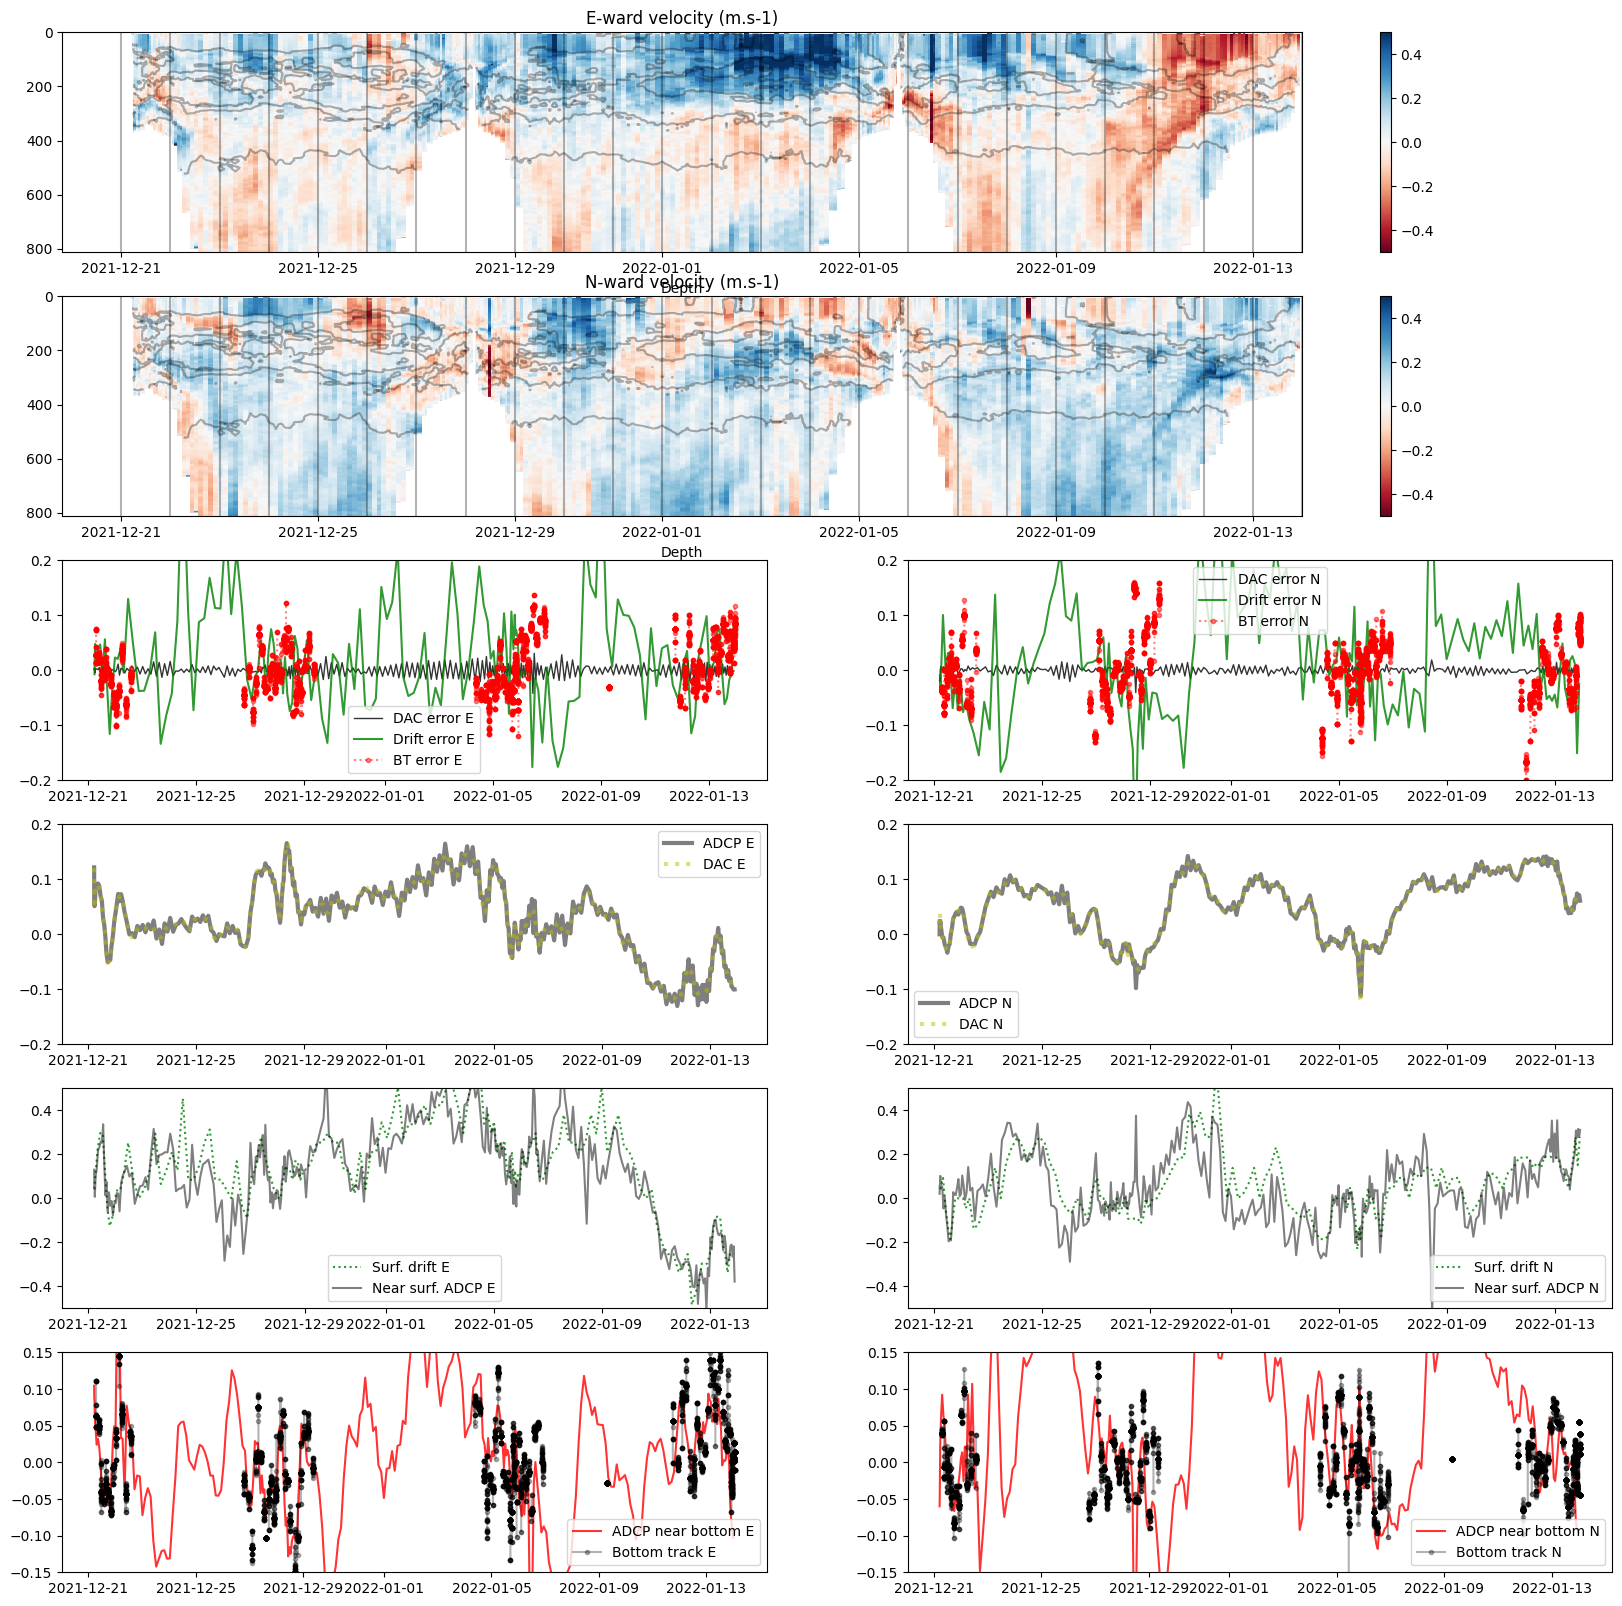

In [24]:
out = process_adcp.reference_shear(ADCP, data, dE,dN,dT, xaxis, yaxis, taxis, options)

## 2.6 Grid and plot data

In [25]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

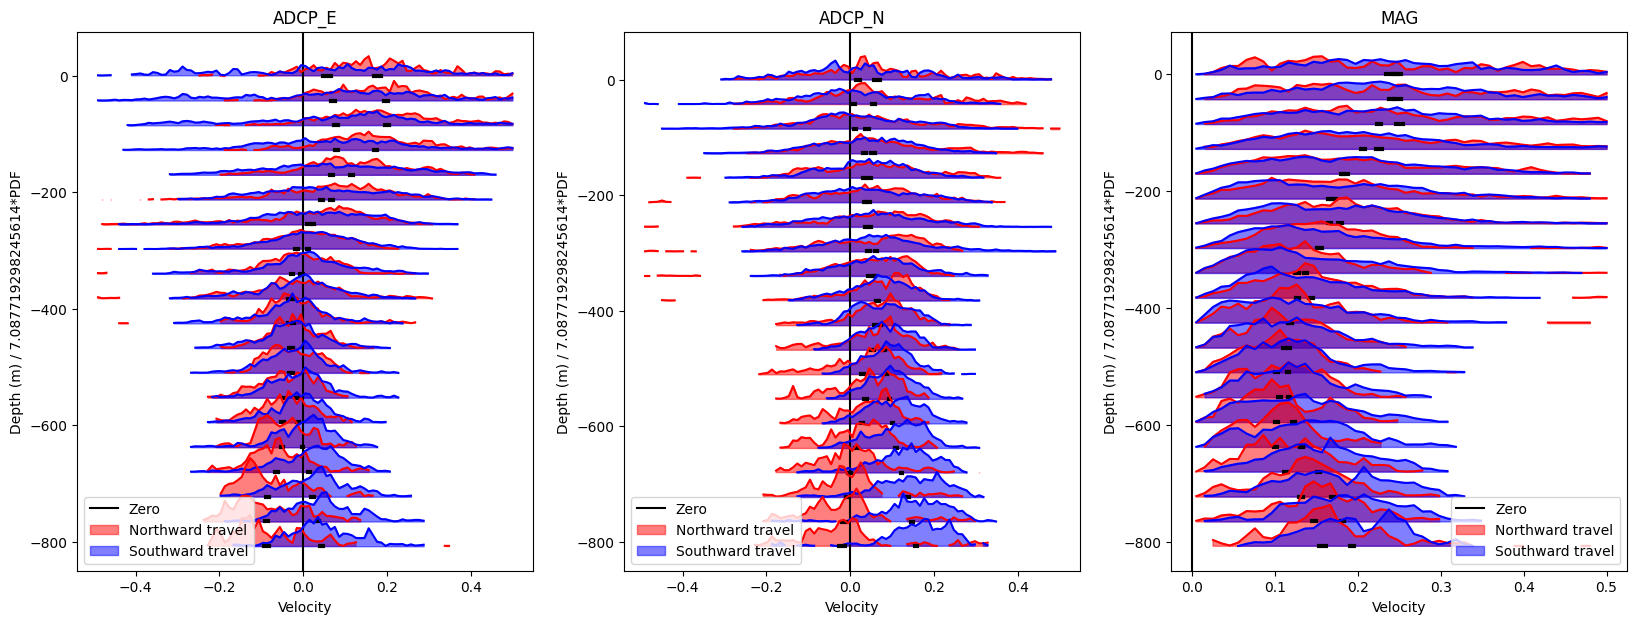

In [26]:
process_adcp.verify_depth_bias(out, yaxis, options)

### 2.7 Correct shear bias

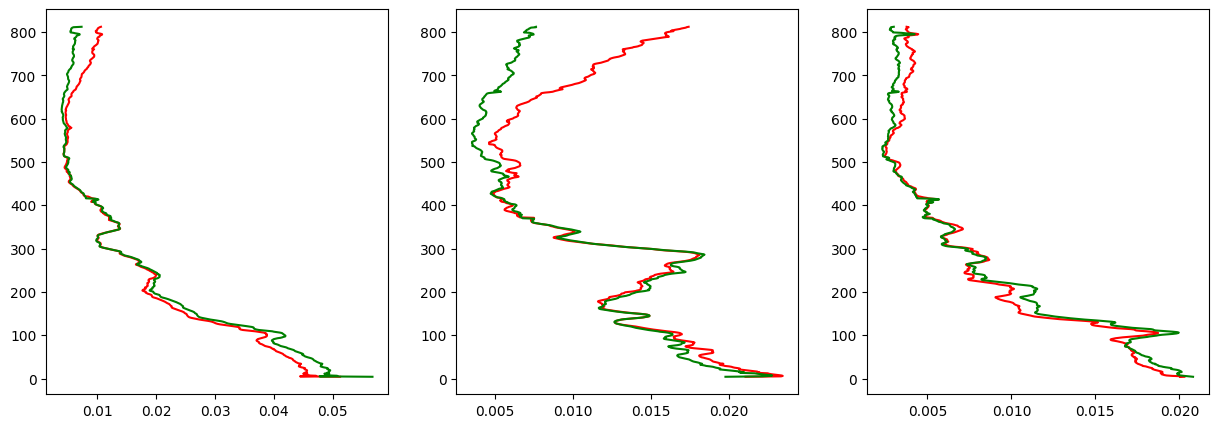

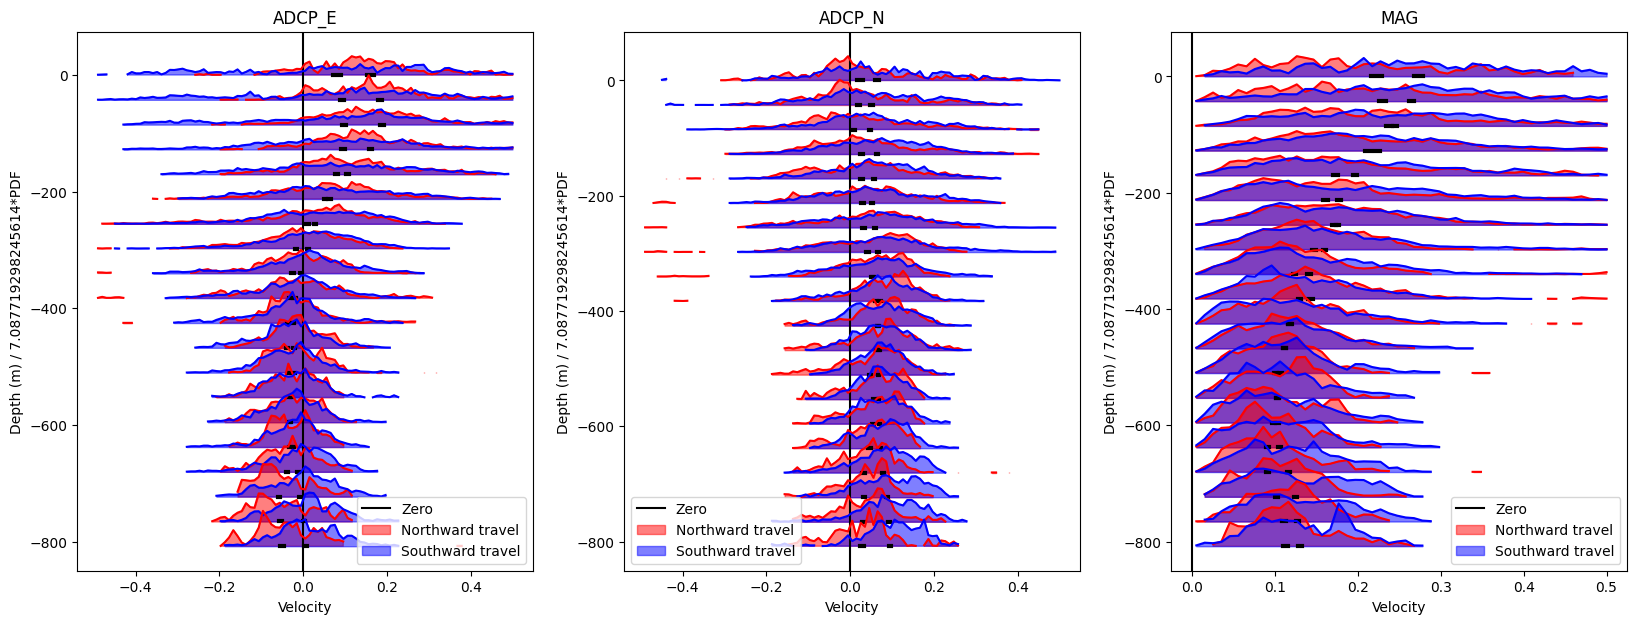

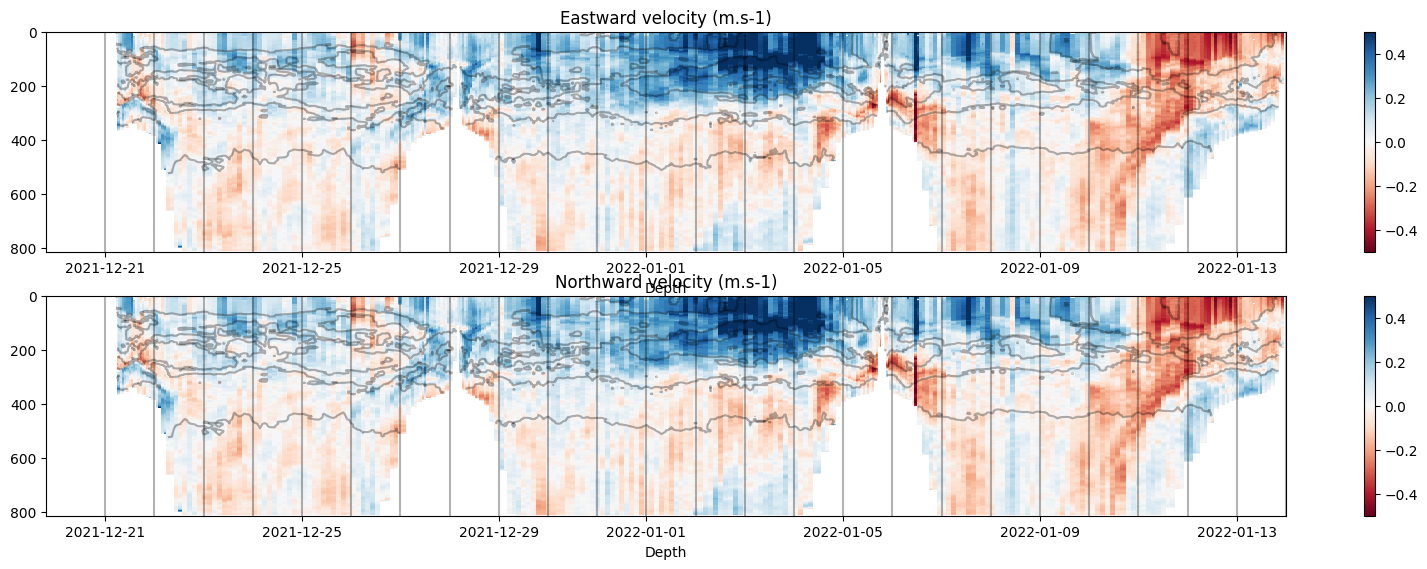

In [27]:
out = process_adcp.calc_bias(out, yaxis, taxis, days, options)

## 2.8 Create xarray DataSet from `out`

In [28]:
ds = process_adcp.make_dataset(out)
ds.to_netcdf("gridded_velocity.nc")